## Install & Import Libraries and Functions

In [1]:
! pip install prophet
! pip install yfinance==0.1.44
! pip install pystan==2.19.1.1 prophet plotly

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# %matplotlib inline
import plotly

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, make_scorer
#mean_absolute_percentage_error
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import cross_val_score
from prophet import Prophet

import scipy
import yfinance as yf
import time
import datetime

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import adfuller

  Using cached prophet-1.0.1-py3-none-any.whl
  Using cached cmdstanpy-0.9.68-py3-none-any.whl (49 kB)
  Using cached ujson-5.1.0-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (44 kB)
  Attempting uninstall: cmdstanpy
    Found existing installation: cmdstanpy 0.9.5
    Uninstalling cmdstanpy-0.9.5:
      Successfully uninstalled cmdstanpy-0.9.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
fbprophet 0.7.1 requires cmdstanpy==0.9.5, but you have cmdstanpy 0.9.68 which is incompatible.
  Using cached yfinance-0.1.44-py3-none-any.whl
  Using cached multitasking-0.0.10-py3-none-any.whl
  Using cached plotly-5.5.0-py2.py3-none-any.whl (26.5 MB)
  Using cached tenacity-8.0.1-py3-none-any.whl (24 kB)


In [2]:
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)
pd.options.display.float_format = '{:,.2f}'.format
plt.rcParams.update({'font.size': 10})

## Read Data (Y-finance & LS)


In [3]:
# Update Today Date
Today=datetime.datetime.now()

In [4]:
#Download from Yahoo finance
ticker="CT=F"
period1=int(time.mktime(datetime.datetime(2000,3,1,23,59).timetuple()))
period2=int(time.mktime(Today.timetuple())) # To update with latest date
# period2=int(time.mktime(datetime.datetime(2023,12,30,23,59).timetuple()))
interval='1d' #1wk,1m

query_string=f'https://query1.finance.yahoo.com/v7/finance/download/{ticker}?period1={period1}&period2={period2}&interval={interval}&events=history&includeAdjustedClose=true'

dfy=pd.read_csv(query_string,parse_dates=['Date'],index_col="Date")

In [5]:
#Download from Yahoo finance
ticker_o="CL=F"
interval='1d' #1wk,1m

query_string_o=f'https://query1.finance.yahoo.com/v7/finance/download/{ticker_o}?period1={period1}&period2={period2}&interval={interval}&events=history&includeAdjustedClose=true'

dfy_o=pd.read_csv(query_string_o,parse_dates=['Date'],index_col="Date")

In [6]:
print(query_string)

https://query1.finance.yahoo.com/v7/finance/download/CT=F?period1=951955140&period2=1644332903&interval=1d&events=history&includeAdjustedClose=true


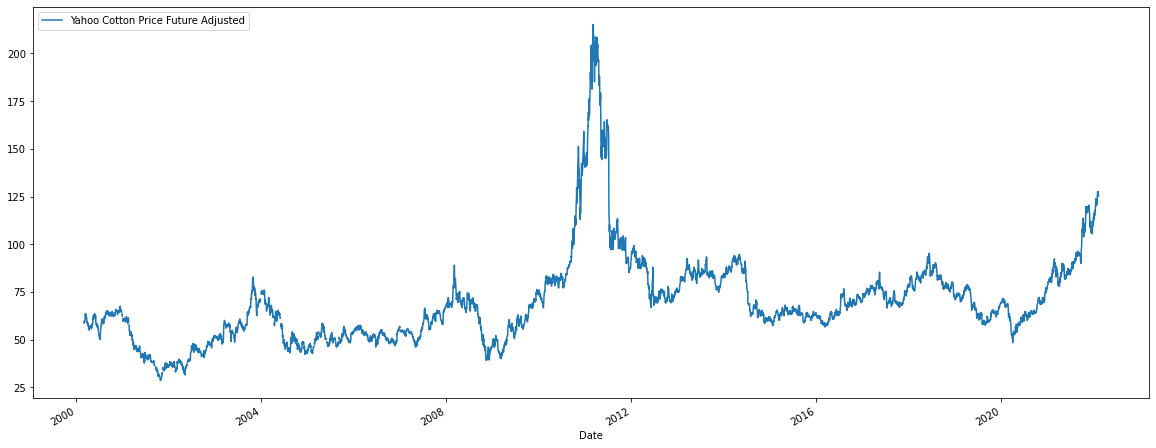

In [7]:
# Yahoo Finance CP data vs. LSE data
plt.clf()
dfy['Adj Close'].plot(label='Yahoo Cotton Price Future Adjusted', legend=True,figsize=(20,8))
# dfy_o['Adj Close'].plot(label='Yahoo Crude Oil Price Future Adjusted', legend=True,figsize=(20,8))
# dfy['Close'].plot(label='Yahoo Cotton Price Future', legend=True)
# dfy['Volume'].plot(label='Volume', secondary_y=True, legend=True)
plt.legend(loc=2)
plt.show()  # show the plot

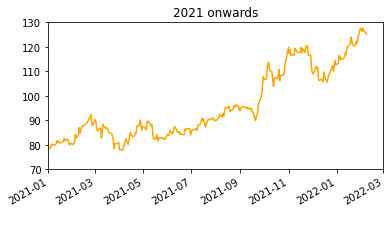

In [8]:
# 2021 onwards
plt.clf()
dfy['Adj Close'].plot(fontsize=10,color="orange",xlabel=" ",figsize=(6,3))
left1 = datetime.date(2021, 1, 1)
right1 = datetime.date(2022, 3, 1)
plt.gca().set_xbound(left1,right1)
plt.gca().set_ybound(70,130)
plt.title(fontsize=12,label="2021 onwards")
plt.show() 

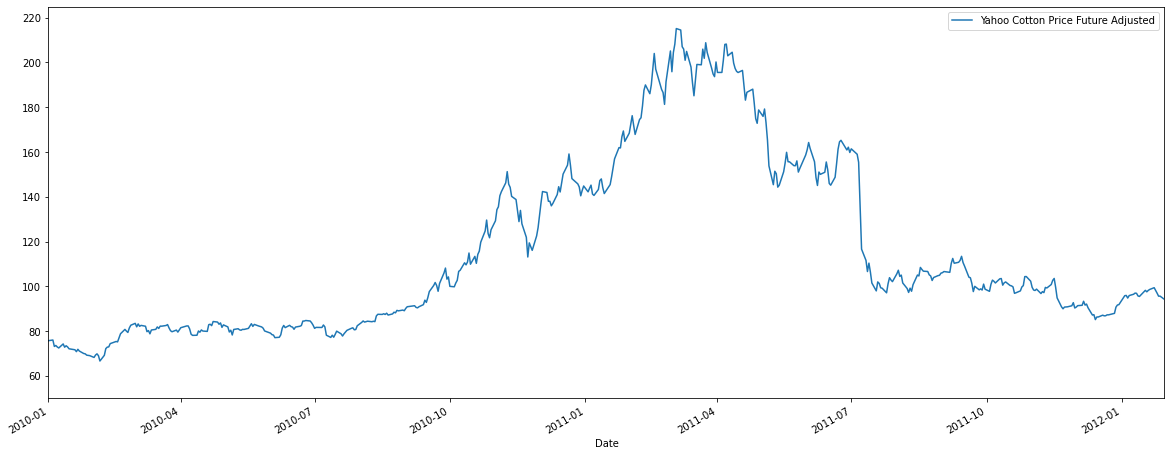

In [9]:
left = datetime.date(2010, 1, 1)
right = datetime.date(2012, 1, 30)

dfy['Adj Close'].plot(label='Yahoo Cotton Price Future Adjusted', legend=True,figsize=(20,8))

plt.gca().set_xbound(left,right)
plt.gca().set_ybound(50,225)

In [10]:
dfy.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5591 entries, 2000-03-01 to 2022-02-08
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       5501 non-null   float64
 1   High       5501 non-null   float64
 2   Low        5501 non-null   float64
 3   Close      5501 non-null   float64
 4   Adj Close  5501 non-null   float64
 5   Volume     5501 non-null   float64
dtypes: float64(6)
memory usage: 305.8 KB


In [11]:
dfy.tail(12)

Open   High    Low  Close  Adj Close    Volume
Date                                                       
2022-01-24 121.20 122.50 119.20 120.38     120.38 17,635.00
2022-01-25 120.40 121.44 120.05 120.92     120.92 13,360.00
2022-01-26 120.93 122.69 120.77 122.33     122.33 12,474.00
2022-01-27 121.92 122.14 120.85 121.63     121.63 10,742.00
2022-01-28 121.80 125.60 120.01 123.76     123.76 22,800.00
2022-01-31 123.76 127.71 123.25 127.57     127.57 19,566.00
2022-02-01 127.45 129.37 124.60 127.33     127.33 25,488.00
2022-02-02 127.46 128.45 125.87 126.33     126.33 15,461.00
2022-02-03 126.20 127.70 125.27 127.62     127.62 18,190.00
2022-02-04 127.70 128.83 125.70 126.74     126.74 21,676.00
2022-02-07 126.76 126.94 125.35 125.57     125.57 21,676.00
2022-02-08 122.95 123.18 122.49 125.22     125.22  6,980.00

In [12]:
#drop null values
dfy=dfy.dropna()
dfy=dfy.drop_duplicates(subset=None, keep='first', inplace=False, ignore_index=False)

In [13]:
dfy.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5498 entries, 2000-03-01 to 2022-02-08
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       5498 non-null   float64
 1   High       5498 non-null   float64
 2   Low        5498 non-null   float64
 3   Close      5498 non-null   float64
 4   Adj Close  5498 non-null   float64
 5   Volume     5498 non-null   float64
dtypes: float64(6)
memory usage: 300.7 KB


In [14]:
dfy.describe()

Open     High      Low    Close  Adj Close    Volume
count 5,498.00 5,498.00 5,498.00 5,498.00   5,498.00  5,498.00
mean     69.59    70.32    68.84    69.54      69.54  7,727.10
std      24.21    24.65    23.76    24.18      24.18  8,743.41
min      28.35    28.95    28.20    28.52      28.52      0.00
25%      54.61    55.10    54.15    54.61      54.61     60.00
50%      65.06    65.65    64.58    64.99      64.99  5,304.50
75%      78.79    79.63    78.16    78.80      78.80 13,170.50
max     215.62   227.00   210.75   215.15     215.15 69,381.00

In [15]:
df_p=dfy[['Adj Close']]
df_p.tail()

Adj Close
Date                 
2022-02-02     126.33
2022-02-03     127.62
2022-02-04     126.74
2022-02-07     125.57
2022-02-08     125.22

In [16]:
# Train Test Split train data till 2020, test data as of 2021
train_df = df_p.loc['2000':'2020', :]
test_df = df_p.loc['2021':'2022-1-20',:]
test_df_plot= df_p.loc['2021':,:]
renaming_dict = {"Date" : "ds", "Adj Close" : "y"}
df_prophet = train_df.copy().reset_index().rename(renaming_dict, axis=1)

test_df1 = test_df.copy().reset_index().rename(renaming_dict, axis=1)

In [17]:
df_prophet.tail(14)

ds     y
5206 2020-12-11 74.08
5207 2020-12-14 74.67
5208 2020-12-15 75.59
5209 2020-12-16 75.65
5210 2020-12-17 77.19
5211 2020-12-18 77.16
5212 2020-12-21 74.76
5213 2020-12-22 74.82
5214 2020-12-23 76.14
5215 2020-12-24 76.20
5216 2020-12-28 76.35
5217 2020-12-29 77.01
5218 2020-12-30 77.97
5219 2020-12-31 78.12

In [18]:
print(test_df1.shape)
test_df1.tail(14)

(265, 2)


ds      y
251 2021-12-31 112.60
252 2022-01-03 113.23
253 2022-01-04 116.39
254 2022-01-05 116.28
255 2022-01-06 114.72
256 2022-01-07 115.12
257 2022-01-10 115.22
258 2022-01-11 116.02
259 2022-01-12 117.64
260 2022-01-13 116.84
261 2022-01-14 119.70
262 2022-01-18 121.08
263 2022-01-19 123.95
264 2022-01-20 122.87

In [19]:
# test_df1=test_df1.drop_duplicates(subset='ds', keep='last', inplace=False, ignore_index=False)

In [20]:
test_df1.tail()

ds      y
260 2022-01-13 116.84
261 2022-01-14 119.70
262 2022-01-18 121.08
263 2022-01-19 123.95
264 2022-01-20 122.87

## Neural Prophet

In [21]:
!pip install neuralprophet[live]
from neuralprophet import NeuralProphet

  Using cached neuralprophet-0.3.0-py3-none-any.whl (67 kB)
  Using cached torch_lr_finder-0.2.1-py3-none-any.whl (11 kB)
  Using cached holidays-0.12-py3-none-any.whl (165 kB)
  Using cached dataclasses-0.6-py3-none-any.whl (14 kB)
  Using cached livelossplot-0.5.4-py3-none-any.whl (22 kB)
  Attempting uninstall: holidays
    Found existing installation: holidays 0.10.5.2
    Uninstalling holidays-0.10.5.2:
      Successfully uninstalled holidays-0.10.5.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
fbprophet 0.7.1 requires cmdstanpy==0.9.5, but you have cmdstanpy 0.9.68 which is incompatible.


INFO - (NP.forecaster._handle_missing_data) - 2391 missing dates added.
INFO - (NP.forecaster._handle_missing_data) - 2391 NaN values in column y were auto-imputed.
  0%|          | 0/250 [00:00<?, ?it/s]WARNING - (py.warnings._showwarnmsg) - /opt/conda/lib/python3.8/site-packages/torch/nn/modules/container.py:552: UserWarning: Setting attributes on ParameterDict is not supported.
  warnings.warn("Setting attributes on ParameterDict is not supported.")

WARNING - (py.warnings._showwarnmsg) - /opt/conda/lib/python3.8/site-packages/torch/autograd/__init__.py:130: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:100.)
  Variable._execution_engine.run_backward(

Epoch[250/250]: 100%|██████████| 250/250 [03:34<00:00,  1.17it/s, SmoothL1Loss=0.000918, MAE=5, RMSE=7.72, RegLoss=0]   
INFO - (NP.fore

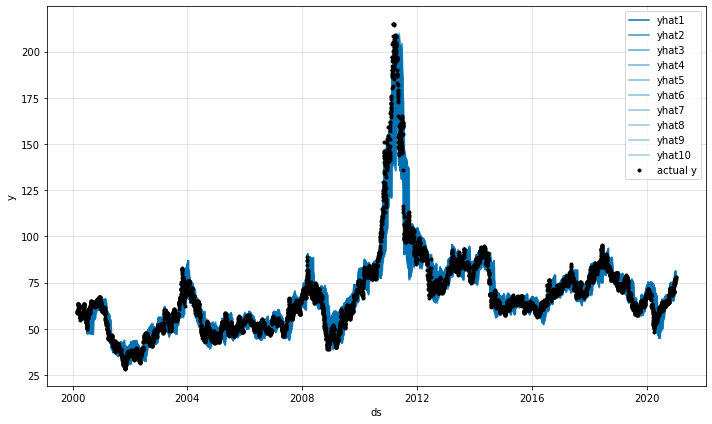

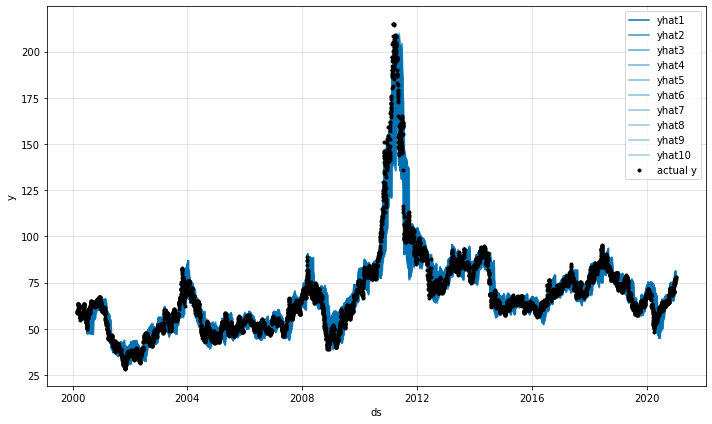

In [22]:
#BASE model to forecast for 60 days 

m = NeuralProphet(daily_seasonality=False, n_lags=100, n_forecasts=80,
                  n_changepoints=5, learning_rate=0.1,epochs=250, 
#                   optimizer="SDG"
#                   num_hidden_layer2=3,
                  batch_size=25, normalize='minmax')

metrics = m.fit(df_prophet, freq='D')
predicted = m.predict(df_prophet)
m.plot(predicted)

INFO - (NP.forecaster._handle_missing_data) - 117 missing dates added.
INFO - (NP.forecaster._handle_missing_data) - 117 NaN values in column y were auto-imputed.
WARNING - (py.warnings._showwarnmsg) - /opt/conda/lib/python3.8/site-packages/torch/nn/modules/container.py:552: UserWarning: Setting attributes on ParameterDict is not supported.
  warnings.warn("Setting attributes on ParameterDict is not supported.")

WARNING - (NP.plotting.plot) - Legend is available only for the ten first handles


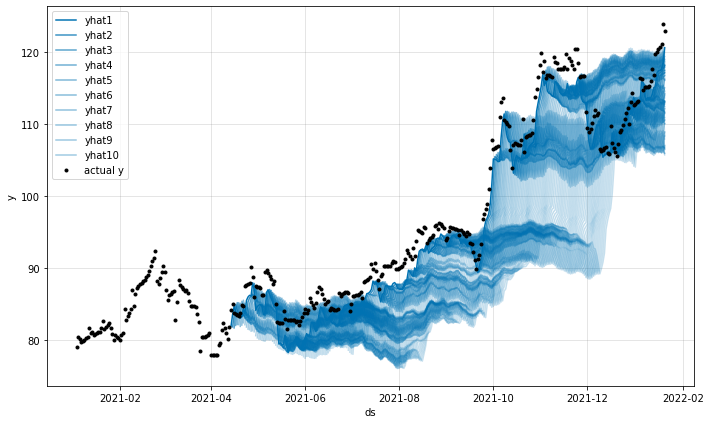

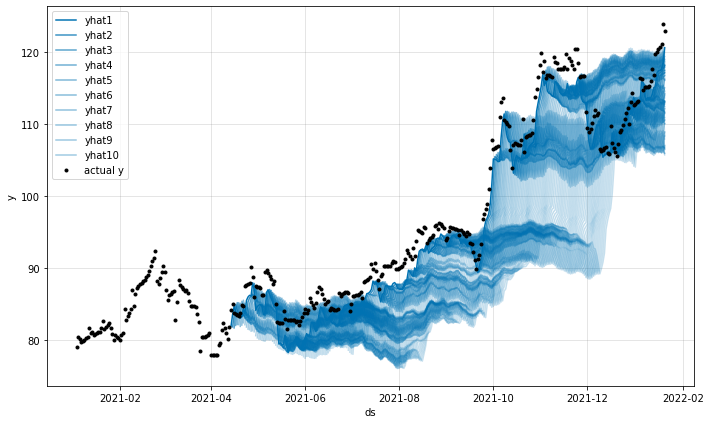

In [23]:
#Need min n_lag row of test data
predicted_test = m.predict(test_df1)
m.plot(predicted_test)
# plt.legend(fontsize=10)

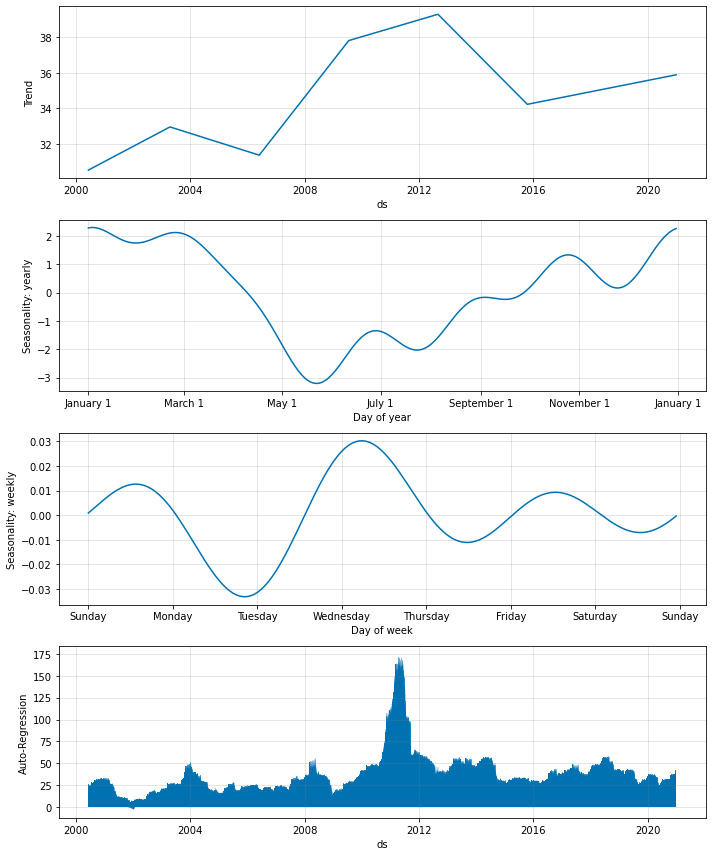

In [24]:
fig_comp = m.plot_components(predicted)

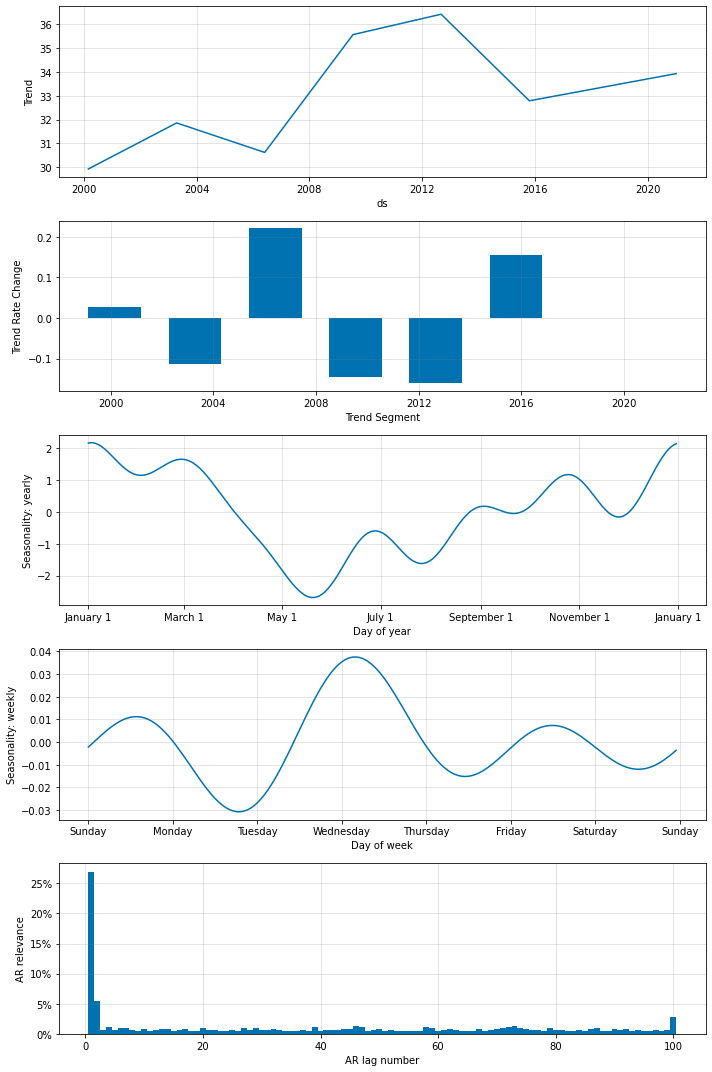

In [55]:
fig_param = m.plot_parameters()

INFO - (NP.forecaster._handle_missing_data) - 117 missing dates added.
INFO - (NP.forecaster._handle_missing_data) - 117 NaN values in column y were auto-imputed.
WARNING - (py.warnings._showwarnmsg) - /opt/conda/lib/python3.8/site-packages/torch/nn/modules/container.py:552: UserWarning: Setting attributes on ParameterDict is not supported.
  warnings.warn("Setting attributes on ParameterDict is not supported.")

WARNING - (NP.plotting.plot) - Legend is available only for the ten first handles


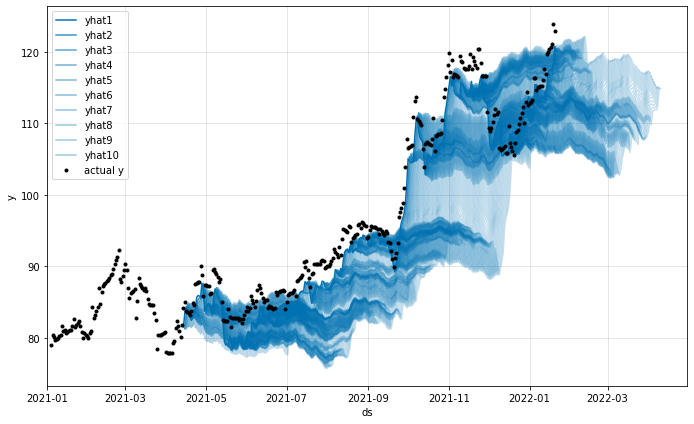

In [31]:
left = datetime.date(2021, 1, 1)
right = datetime.date(2022, 4, 30)
future = m.make_future_dataframe(test_df1, periods=80, n_historic_predictions=True)
forecast = m.predict(future)
m.plot(forecast)
plt.gca().set_xbound(left,right)

WARNING - (NP.plotting.plot) - Legend is available only for the ten first handles


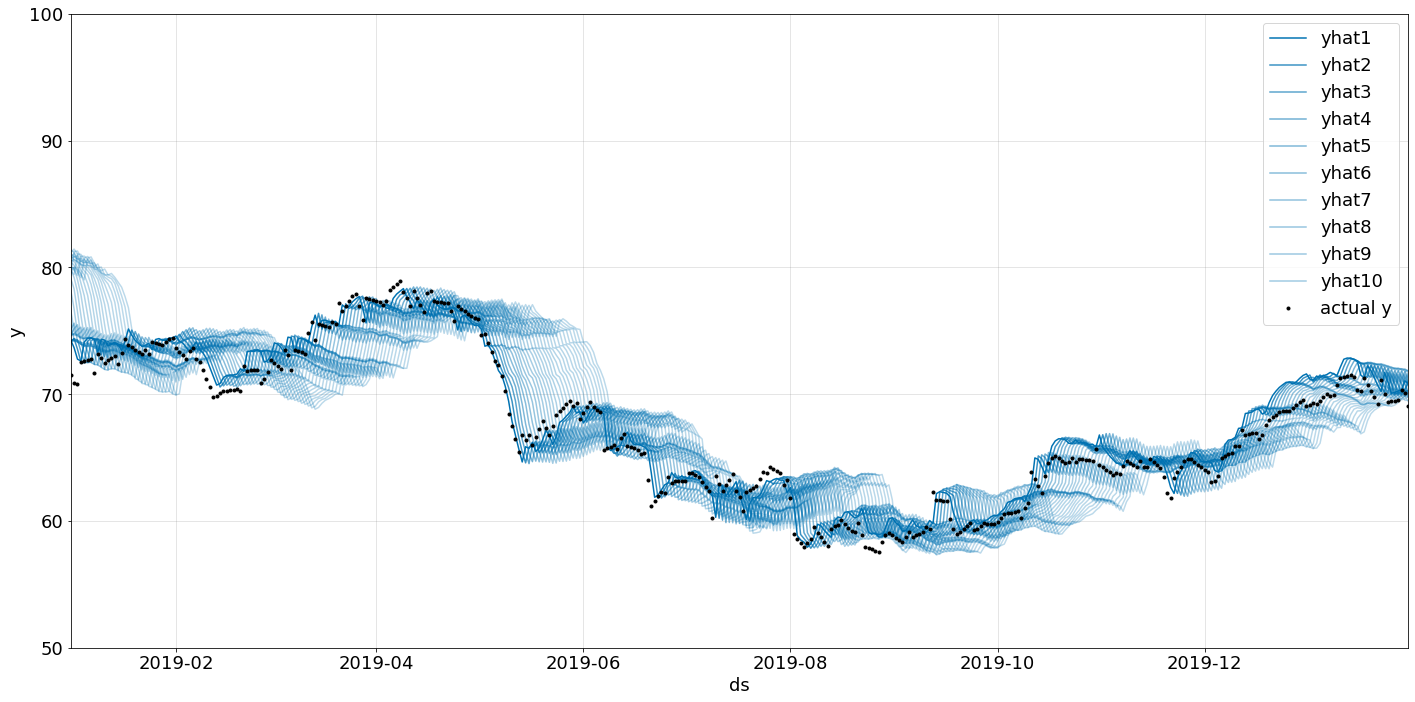

In [71]:
# Not used, only for full date model
left = datetime.date(2019, 1, 1)
right = datetime.date(2020, 1, 30)


m.plot(predicted, figsize=(20,10))
plt.gca().set_xbound(left,right)
plt.gca().set_ybound(50,100)

WARNING - (NP.plotting.plot) - Legend is available only for the ten first handles


[]

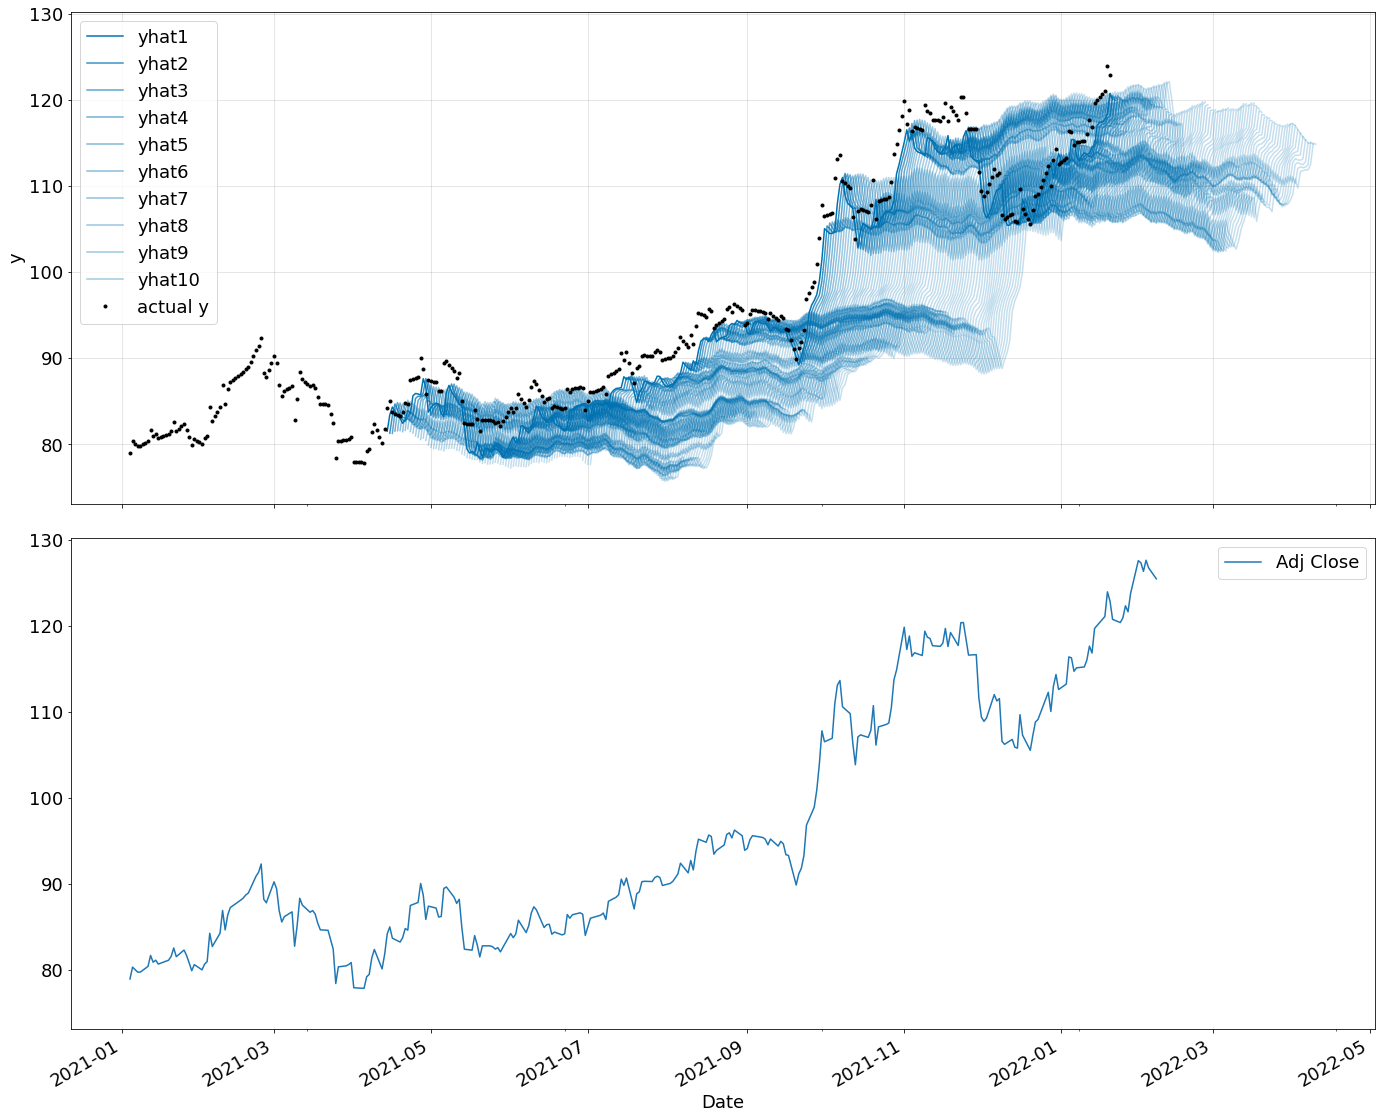

In [32]:
left = datetime.date(2021, 1, 1)
right = datetime.date(2022, 3, 30)
plt.rcParams.update({'font.size': 18})
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(20, 18),sharex=True,sharey=True)

m.plot(forecast,ax=axes[0])
plt.gca().set_xbound(left,right)
test_df_plot.plot(ax=axes[1])


plt.plot()

In [49]:
test_df1.tail(15)

ds      y
237 2021-12-10 106.23
238 2021-12-13 106.81
239 2021-12-14 105.90
240 2021-12-15 105.79
241 2021-12-16 109.68
242 2021-12-17 107.30
243 2021-12-20 105.54
244 2021-12-21 107.27
245 2021-12-22 108.83
246 2021-12-23 109.12
247 2021-12-27 112.28
248 2021-12-28 110.05
249 2021-12-29 112.99
250 2021-12-30 114.34
251 2021-12-31 112.60

In [37]:
forecast.tail(63)

ds   y yhat1 residual1 yhat2 residual2 yhat3 residual3 yhat4  \
399 2022-02-07 NaN  None       NaN  None       NaN  None       NaN  None   
400 2022-02-08 NaN  None       NaN  None       NaN  None       NaN  None   
401 2022-02-09 NaN  None       NaN  None       NaN  None       NaN  None   
402 2022-02-10 NaN  None       NaN  None       NaN  None       NaN  None   
403 2022-02-11 NaN  None       NaN  None       NaN  None       NaN  None   
404 2022-02-12 NaN  None       NaN  None       NaN  None       NaN  None   
405 2022-02-13 NaN  None       NaN  None       NaN  None       NaN  None   
406 2022-02-14 NaN  None       NaN  None       NaN  None       NaN  None   
407 2022-02-15 NaN  None       NaN  None       NaN  None       NaN  None   
408 2022-02-16 NaN  None       NaN  None       NaN  None       NaN  None   
409 2022-02-17 NaN  None       NaN  None       NaN  None       NaN  None   
410 2022-02-18 NaN  None       NaN  None       NaN  None       NaN  None   
411 2022-02-19 NaN  None       NaN  None       NaN  None       NaN  None   
412 2022-02-20 NaN  None       NaN  None       NaN  None       NaN  None   
413 2022-02-21 NaN  None       NaN  None       NaN  None       NaN  None   
414 2022-02-22 NaN  None       NaN  None       NaN  None       NaN  None   
415 2022-02-23 NaN  None       NaN  None       NaN  None       NaN  None   
416 2022-02-24 NaN  None       NaN  None       NaN  None       NaN  None   
417 2022-02-25 NaN  None       NaN  None       NaN  None       NaN  None   
418 2022-02-26 NaN  None       NaN  None       NaN  None       NaN  None   
419 2022-02-27 NaN  None       NaN  None       NaN  None       NaN  None   
420 2022-02-28 NaN  None       NaN  None       NaN  None       NaN  None   
421 2022-03-01 NaN  None       NaN  None       NaN  None       NaN  None   
422 2022-03-02 NaN  None       NaN  None       NaN  None       NaN  None   
423 2022-03-03 NaN  None       NaN  None       NaN  None       NaN  None   
424 2022-03-04 NaN  None       NaN  None       NaN  None       NaN  None   
425 2022-03-05 NaN  None       NaN  None       NaN  None       NaN  None   
426 2022-03-06 NaN  None       NaN  None       NaN  None       NaN  None   
427 2022-03-07 NaN  None       NaN  None       NaN  None       NaN  None   
428 2022-03-08 NaN  None       NaN  None       NaN  None       NaN  None   
429 2022-03-09 NaN  None       NaN  None       NaN  None       NaN  None   
430 2022-03-10 NaN  None       NaN  None       NaN  None       NaN  None   
431 2022-03-11 NaN  None       NaN  None       NaN  None       NaN  None   
432 2022-03-12 NaN  None       NaN  None       NaN  None       NaN  None   
433 2022-03-13 NaN  None       NaN  None       NaN  None       NaN  None   
434 2022-03-14 NaN  None       NaN  None       NaN  None       NaN  None   
435 2022-03-15 NaN  None       NaN  None       NaN  None       NaN  None   
436 2022-03-16 NaN  None       NaN  None       NaN  None       NaN  None   
437 2022-03-17 NaN  None       NaN  None       NaN  None       NaN  None   
438 2022-03-18 NaN  None       NaN  None       NaN  None       NaN  None   
439 2022-03-19 NaN  None       NaN  None       NaN  None       NaN  None   
440 2022-03-20 NaN  None       NaN  None       NaN  None       NaN  None   
441 2022-03-21 NaN  None       NaN  None       NaN  None       NaN  None   
442 2022-03-22 NaN  None       NaN  None       NaN  None       NaN  None   
443 2022-03-23 NaN  None       NaN  None       NaN  None       NaN  None   
444 2022-03-24 NaN  None       NaN  None       NaN  None       NaN  None   
445 2022-03-25 NaN  None       NaN  None       NaN  None       NaN  None   
446 2022-03-26 NaN  None       NaN  None       NaN  None       NaN  None   
447 2022-03-27 NaN  None       NaN  None       NaN  None       NaN  None   
448 2022-03-28 NaN  None       NaN  None       NaN  None       NaN  None   
449 2022-03-29 NaN  None       NaN  None       NaN  None       NaN  None   
450 2022-03-30 NaN  None       NaN  None       NaN  None    

In [21]:
df_forecast=forecast.filter(regex="yhat") # only yhat variables

In [25]:
# df_forecast_1.head()

ds     y  yhat1  residual1  yhat2  residual2  yhat3  residual3  \
0  2020-01-02 69.27    NaN        NaN    NaN        NaN    NaN        NaN   
1  2020-01-03 69.20    NaN        NaN    NaN        NaN    NaN        NaN   
2  2020-01-04 69.48    NaN        NaN    NaN        NaN    NaN        NaN   
3  2020-01-05 69.76    NaN        NaN    NaN        NaN    NaN        NaN   
4  2020-01-06 70.04    NaN        NaN    NaN        NaN    NaN        NaN   

   yhat4  residual4  yhat5  residual5  yhat6  residual6  yhat7  residual7  \
0    NaN        NaN    NaN        NaN    NaN        NaN    NaN        NaN   
1    NaN        NaN    NaN        NaN    NaN        NaN    NaN        NaN   
2    NaN        NaN    NaN        NaN    NaN        NaN    NaN        NaN   
3    NaN        NaN    NaN        NaN    NaN        NaN    NaN        NaN   
4    NaN        NaN    NaN        NaN    NaN        NaN    NaN        NaN   

   yhat8  residual8  yhat9  residual9  yhat10  residual10  yhat11  residual11  \
0    NaN        NaN    NaN        NaN     NaN         NaN     NaN         NaN   
1    NaN        NaN    NaN        NaN     NaN         NaN     NaN         NaN   
2    NaN        NaN    NaN        NaN     NaN         NaN     NaN         NaN   
3    NaN        NaN    NaN        NaN     NaN         NaN     NaN         NaN   
4    NaN        NaN    NaN        NaN     NaN         NaN     NaN         NaN   

   yhat12  residual12  yhat13  residual13  yhat14  residual14  yhat15  \
0     NaN         NaN     NaN         NaN     NaN         NaN     NaN   
1     NaN         NaN     NaN         NaN     NaN         NaN     NaN   
2     NaN         NaN     NaN         NaN     NaN         NaN     NaN   
3     NaN         NaN     NaN         NaN     NaN         NaN     NaN   
4     NaN         NaN     NaN         NaN     NaN         NaN     NaN   

   residual15  yhat16  residual16  yhat17  residual17  yhat18  residual18  \
0         NaN     NaN         NaN     NaN         NaN     NaN         NaN   
1         NaN     NaN         NaN     NaN         NaN     NaN         NaN   
2         NaN     NaN         NaN     NaN         NaN     NaN         NaN   
3         NaN     NaN         NaN     NaN         NaN     NaN         NaN   
4         NaN     NaN         NaN     NaN         NaN     NaN         NaN   

   yhat19  residual19  yhat20  residual20  yhat21  residual21  yhat22  \
0     NaN         NaN     NaN         NaN     NaN         NaN     NaN   
1     NaN         NaN     NaN         NaN     NaN         NaN     NaN   
2     NaN         NaN     NaN         NaN     NaN         NaN     NaN   
3     NaN         NaN     NaN         NaN     NaN         NaN     NaN   
4     NaN         NaN     NaN         NaN     NaN         NaN     NaN   

   residual22  yhat23  residual23  yhat24  residual24  yhat25  residual25  \
0         NaN     NaN         NaN     NaN         NaN     NaN         NaN   
1         NaN     NaN         NaN     NaN         NaN     NaN         NaN   
2         NaN     NaN         NaN     NaN         NaN     NaN         NaN   
3         NaN     NaN         NaN     NaN         NaN     NaN         NaN   
4         NaN     NaN         NaN     NaN         NaN     NaN         NaN   

   yhat26  residual26  yhat27  residual27  yhat28  residual28  yhat29  \
0     NaN         NaN     NaN         NaN     NaN         NaN     NaN   
1     NaN         NaN     NaN         NaN     NaN         NaN     NaN   
2     NaN         NaN     NaN         NaN     NaN         NaN     NaN   
3     NaN         NaN     NaN         NaN     NaN         NaN     NaN   
4     NaN         NaN     NaN         NaN     NaN         NaN     NaN   

   residual29  yhat30  residual30  ar1  ar2  ar3  ar4  ar5  ar6  ar7  ar8  \
0         NaN     NaN         NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
1         NaN     NaN         NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
2         NaN     NaN         NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
3         NaN     NaN         NaN  NaN  NaN  Na

In [23]:
df_forecast.tail()

yhat1 yhat2 yhat3 yhat4 yhat5 yhat6 yhat7 yhat8 yhat9 yhat10 yhat11  \
776  None  None  None  None  None  None  None  None  None   None   None   
777  None  None  None  None  None  None  None  None  None   None   None   
778  None  None  None  None  None  None  None  None  None   None   None   
779  None  None  None  None  None  None  None  None  None   None   None   
780  None  None  None  None  None  None  None  None  None   None   None   

    yhat12 yhat13 yhat14 yhat15 yhat16 yhat17 yhat18 yhat19 yhat20 yhat21  \
776   None   None   None   None   None   None   None   None   None   None   
777   None   None   None   None   None   None   None   None   None   None   
778   None   None   None   None   None   None   None   None   None   None   
779   None   None   None   None   None   None   None   None   None   None   
780   None   None   None   None   None   None   None   None   None   None   

    yhat22 yhat23 yhat24 yhat25 yhat26 yhat27 yhat28 yhat29 yhat30 yhat31  \
776   None   None   None   None   None   None   None   None   None   None   
777   None   None   None   None   None   None   None   None   None   None   
778   None   None   None   None   None   None   None   None   None   None   
779   None   None   None   None   None   None   None   None   None   None   
780   None   None   None   None   None   None   None   None   None   None   

    yhat32 yhat33 yhat34 yhat35 yhat36 yhat37 yhat38 yhat39 yhat40 yhat41  \
776   None   None   None   None   None   None   None   None   None   None   
777   None   None   None   None   None   None   None   None   None   None   
778   None   None   None   None   None   None   None   None   None   None   
779   None   None   None   None   None   None   None   None   None   None   
780   None   None   None   None   None   None   None   None   None   None   

    yhat42 yhat43 yhat44 yhat45 yhat46 yhat47 yhat48 yhat49 yhat50 yhat51  \
776   None   None   None   None   None   None   None   None   None   None   
777   None   None   None   None   None   None   None   None   None   None   
778   None   None   None   None   None   None   None   None   None   None   
779   None   None   None   None   None   None   None   None   None   None   
780   None   None   None   None   None   None   None   None   None   None   

    yhat52 yhat53 yhat54 yhat55 yhat56 yhat57 yhat58 yhat59 yhat60  
776   None   None   None   None 108.37 106.94 105.48 105.78 106.76  
777   None   None   None   None   None 108.47 106.83 105.36 105.88  
778   None   None   None   None   None   None 108.27 106.79 104.95  
779   None   None   None   None   None   None   None 108.09 106.68  
780   None   None   None   None   None   None   None   None 108.57

In [24]:
df_yhat=df_forecast.fillna(method="ffill")
# df_yhat_1=df_forecast_1.fillna(method="ffill")
# df_yhat_2=forecast.fillna(method="ffill")

# DEC 7th Prediction

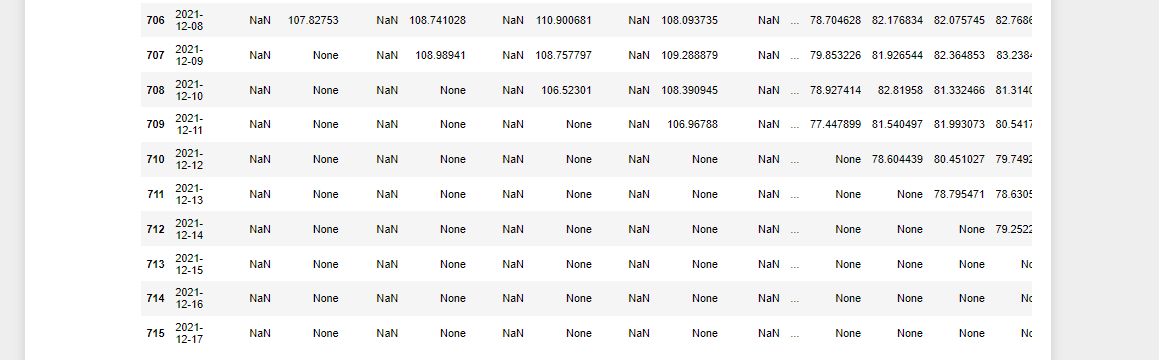

In [25]:
df_yhat.filter(regex="yhat")

yhat1  yhat2  yhat3  yhat4  yhat5  yhat6  yhat7  yhat8  yhat9  yhat10  \
0      NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN     NaN   
1      NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN     NaN   
2      NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN     NaN   
3      NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN     NaN   
4      NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN     NaN   
5      NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN     NaN   
6      NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN     NaN   
7      NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN     NaN   
8      NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN     NaN   
9      NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN     NaN   
10     NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN     NaN   
11     NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN     NaN   
12     NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN     NaN   
13     NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN     NaN   
14     NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN     NaN   
15     NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN     NaN   
16     NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN     NaN   
17     NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN     NaN   
18     NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN     NaN   
19     NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN     NaN   
20     NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN     NaN   
21     NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN     NaN   
22     NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN     NaN   
23     NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN     NaN   
24     NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN     NaN   
25     NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN     NaN   
26     NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN     NaN   
27     NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN     NaN   
28     NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN     NaN   
29     NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN     NaN   
30     NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN     NaN   
31     NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN     NaN   
32     NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN     NaN   
33     NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN     NaN   
34     NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN     NaN   
35     NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN     NaN   
36     NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN     NaN   
37     NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN     NaN   
38     NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN     NaN   
39     NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN     NaN   
40     NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN     NaN   
41     NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN     NaN   
42     NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN     NaN   
43     NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN     NaN   
44     NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN     NaN   
45     NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN     NaN   
46     NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN     NaN   
47     NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN     NaN   
48     NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN     NaN   
49     NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN     NaN   
50     NaN    NaN    NaN   

In [26]:
df_pred=df_yhat.iloc[-1].filter(regex="yhat").tolist() #prediction values last row
# df_pred_1=df_yhat_1.iloc[-1].filter(regex="yhat").tolist() #prediction values last row
# df_pred_2=df_yhat_2.iloc[-1].filter(regex="yhat").tolist() #prediction values last row

In [27]:
df_pred

[109.9451904296875,
 110.05885314941406,
 110.41252136230469,
 110.49028015136719,
 110.90299987792969,
 111.40371704101562,
 111.39712524414062,
 111.37841796875,
 110.87678527832031,
 110.75918579101562,
 110.68621826171875,
 110.64350891113281,
 110.63754272460938,
 111.1026611328125,
 111.152587890625,
 110.62699890136719,
 110.37722778320312,
 110.07696533203125,
 110.03404235839844,
 109.65638732910156,
 109.54966735839844,
 109.51220703125,
 109.52748107910156,
 109.91529846191406,
 109.95552062988281,
 109.89849853515625,
 109.73164367675781,
 109.71296691894531,
 109.49140930175781,
 109.53378295898438,
 109.52082824707031,
 109.73454284667969,
 109.64115905761719,
 109.59115600585938,
 109.64857482910156,
 109.81126403808594,
 110.26353454589844,
 110.36862182617188,
 110.41096496582031,
 110.53150939941406,
 110.45442199707031,
 110.3431396484375,
 110.29122924804688,
 109.76028442382812,
 109.49148559570312,
 109.4791259765625,
 109.49069213867188,
 109.50859069824219,
 109

In [28]:
IDX=df_forecast.yhat1.last_valid_index()
# IDX_1=df_forecast_1.yhat1.last_valid_index()
# IDX_2=forecast.yhat1.last_valid_index()

In [30]:
df_dates=forecast.ds.iloc[IDX:].tolist()
# df_dates_1=df_forecast_1.ds.iloc[IDX_1:].tolist()
# df_dates_2=forecast.ds.iloc[IDX_2:].tolist()

In [31]:
len(df_pred)

60

In [35]:
final_df=pd.DataFrame({"Date":df_dates,"Predictions":df_pred}).set_index("Date")
# final_df_1=pd.DataFrame({"Date":df_dates_1,"Predictions":df_pred_1}).set_index("Date")
final_df.head()

Predictions
Date                   
2021-12-23       109.95
2021-12-24       110.06
2021-12-25       110.41
2021-12-26       110.49
2021-12-27       110.90

In [36]:
final_df.setindex()

AttributeError: 'DataFrame' object has no attribute 'setindex'

In [37]:
# final_df_2=pd.DataFrame({"Date":df_dates_2,"Predictions":df_pred_2}).set_index("Date")

In [45]:
# final_df_2

Predictions
Date                   
2021-12-18       106.99
2021-12-19       105.55
2021-12-20       104.28
2021-12-21       105.21
2021-12-22       104.67
2021-12-23       104.72
2021-12-24       106.10
2021-12-25       104.78
2021-12-26       105.25
2021-12-27       106.32
2021-12-28       106.09
2021-12-29       105.46
2021-12-30       106.57
2021-12-31       105.59
2022-01-01       105.06
2022-01-02       106.04
2022-01-03       105.33
2022-01-04       106.13
2022-01-05       107.32
2022-01-06       106.46
2022-01-07       103.59
2022-01-08       106.40
2022-01-09       105.49
2022-01-10       104.74
2022-01-11       105.50
2022-01-12       105.92
2022-01-13       106.22
2022-01-14       104.78
2022-01-15       104.82
2022-01-16       106.25
2022-01-17       104.83
2022-01-18       106.66
2022-01-19       105.12
2022-01-20       106.42
2022-01-21       105.55
2022-01-22       106.80
2022-01-23       105.68
2022-01-24       104.98
2022-01-25       107.12
2022-01-26       104.82
2022-01-27       106.69
2022-01-28       104.72
2022-01-29       103.96
2022-01-30       104.46
2022-01-31       107.46
2022-02-01       105.55
2022-02-02       107.37
2022-02-03       105.48
2022-02-04       105.18
2022-02-05       106.74
2022-02-06       105.39
2022-02-07       106.19
2022-02-08       106.02
2022-02-09       105.38
2022-02-10       105.37
2022-02-11       105.53
2022-02-12       105.83
2022-02-13       105.54
2022-02-14       104.21
2022-02-15       104.56
2022-02-16       103.63
2022-02-17       104.12
2022-02-18       105.32
2022-02-19       103.09
2022-02-20       104.16
2022-02-21       103.44
2022-02-22       103.36
2022-02-23       105.03
2022-02-24       103.47
2022-02-25       102.94
2022-02-26       104.49
2022-02-27       104.51
2022-02-28       104.25
2022-03-01       101.51
2022-03-02       102.03
2022-03-03       102.69
2022-03-04       102.53
2022-03-05       101.29
2022-03-06       103.14
2022-03-07       102.62
2022-03-08       102.59
2022-03-09       103.12
2022-03-10       103.47
2022-03-11       102.04
2022-03-12       103.57
2022-03-13       102.67
2022-03-14       103.05
2022-03-15       102.37
2022-03-16       102.82
2022-03-17       102.27
2022-03-18       103.67
2022-03-19       102.71
2022-03-20       101.36
2022-03-21       102.34
2022-03-22       101.68
2022-03-23       102.27
2022-03-24        99.45
2022-03-25       101.25
2022-03-26        98.58
2022-03-27        99.27

In [49]:
df_pred.

dtype('O')

In [38]:
test_df.tail()

Adj Close
Date                 
2021-12-13     106.81
2021-12-14     105.90
2021-12-15     105.79
2021-12-16     109.68
2021-12-17     107.30

In [ ]:
final_df.tail()

In [ ]:
test_df.tail(10)

In [57]:
final_df_2.tail(10)

Predictions
Date                   
2022-03-18       103.67
2022-03-19       102.71
2022-03-20       101.36
2022-03-21       102.34
2022-03-22       101.68
2022-03-23       102.27
2022-03-24        99.45
2022-03-25       101.25
2022-03-26        98.58
2022-03-27        99.27

In [55]:
final_df_2.head(10)

Predictions
Date                   
2021-12-18       106.99
2021-12-19       105.55
2021-12-20       104.28
2021-12-21       105.21
2021-12-22       104.67
2021-12-23       104.72
2021-12-24       106.10
2021-12-25       104.78
2021-12-26       105.25
2021-12-27       106.32

## Plot Data Predicted

<AxesSubplot:xlabel='Date'>

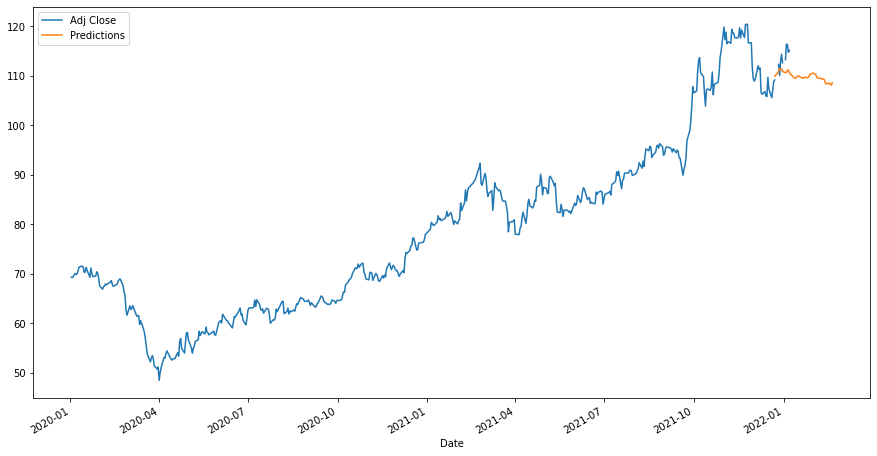

In [39]:
df_plot=pd.concat([test_df_plot,final_df],axis=1)
# df_plot.columns()
# # df_plot.columns((["Prediction", "Actual_to_date","Prediction_1"])
# # df_plot.to_csv('plot_data.csv',index=False)
df_plot.plot(figsize=(15,8),legend=True)

<AxesSubplot:xlabel='Date'>

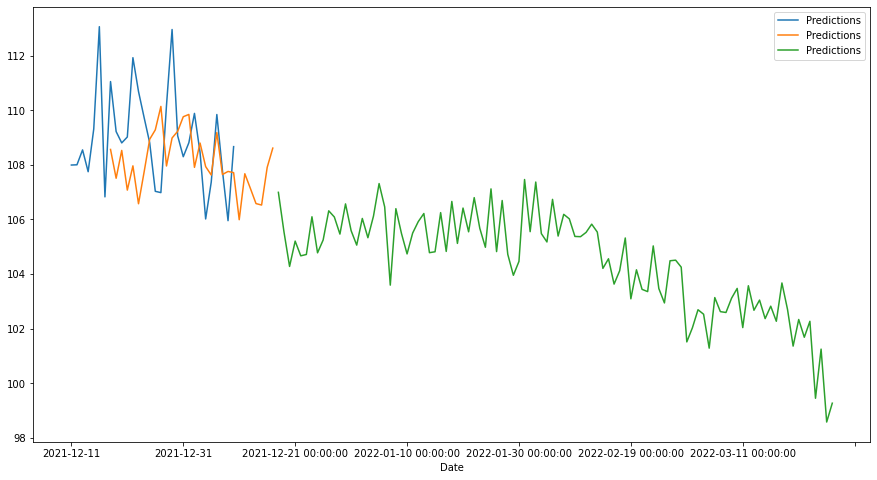

In [49]:
df_plot=pd.concat([final_df,final_df_1,final_df_2],axis=1)
# df_plot.columns()
# # df_plot.columns((["Prediction", "Actual_to_date","Prediction_1"])
# # df_plot.to_csv('plot_data.csv',index=False)
df_plot.plot(figsize=(15,8),legend=True)

WARNING - (NP.forecaster.__init__) - Changing n_forecasts to 1. Without lags, the forecast can be computed for any future time, independent of lagged values


  0%|          | 0/284 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 3.42E-02, min: 9.22E-01


  0%|          | 0/284 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 2.74E-02, min: 9.22E-01


  0%|          | 0/284 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 2.74E-02, min: 9.22E-01
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 2.95E-02
Epoch[5/5]: 100%|██████████| 5/5 [00:00<00:00,  7.43it/s, SmoothL1Loss=0.00536, MAE=12.1, RMSE=19.1, RegLoss=0]


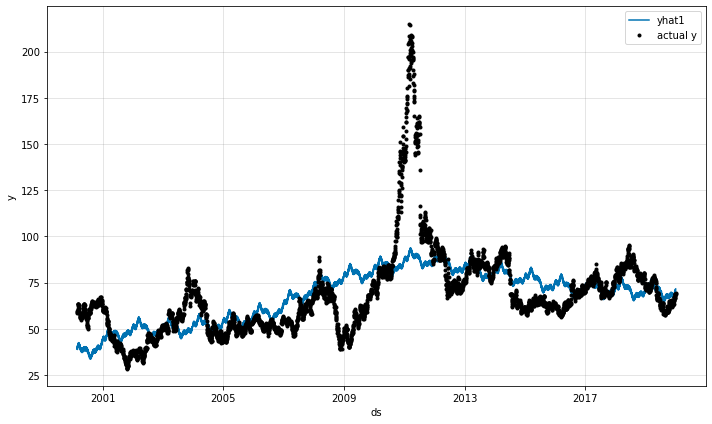

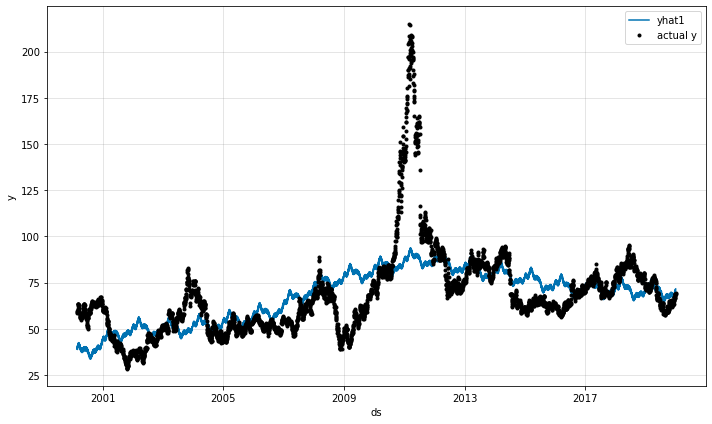

In [27]:
#remove n_lag=2

m1 = NeuralProphet(daily_seasonality=True, n_forecasts=10, epochs=5, batch_size=100, normalize='minmax')

metrics1 = m1.fit(df_prophet, freq='D')
predicted1 = m1.predict(df_prophet)
m1.plot(predicted1)


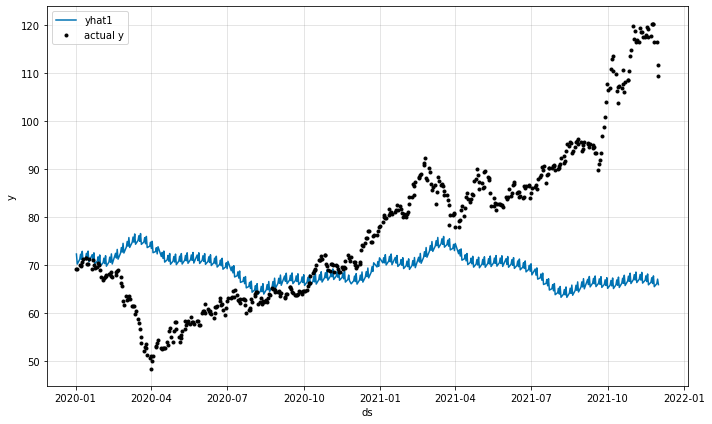

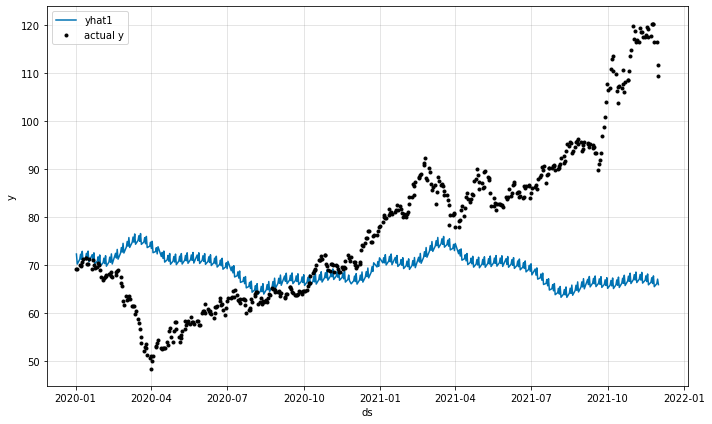

In [28]:
predicted_test1 = m1.predict(test_df1)
m.plot(predicted_test1)

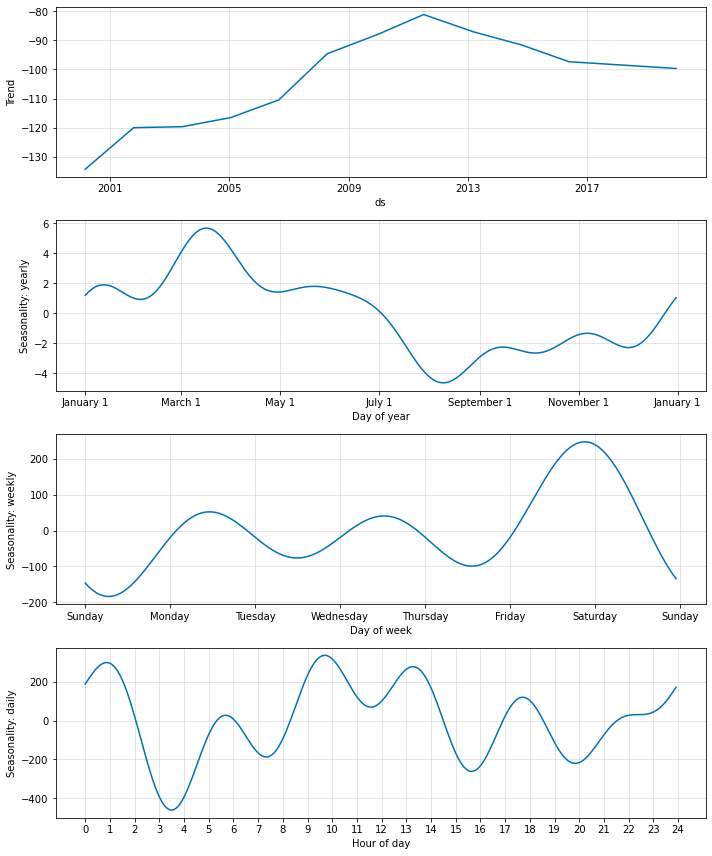

In [29]:
fig_comp1 = m1.plot_components(predicted1)

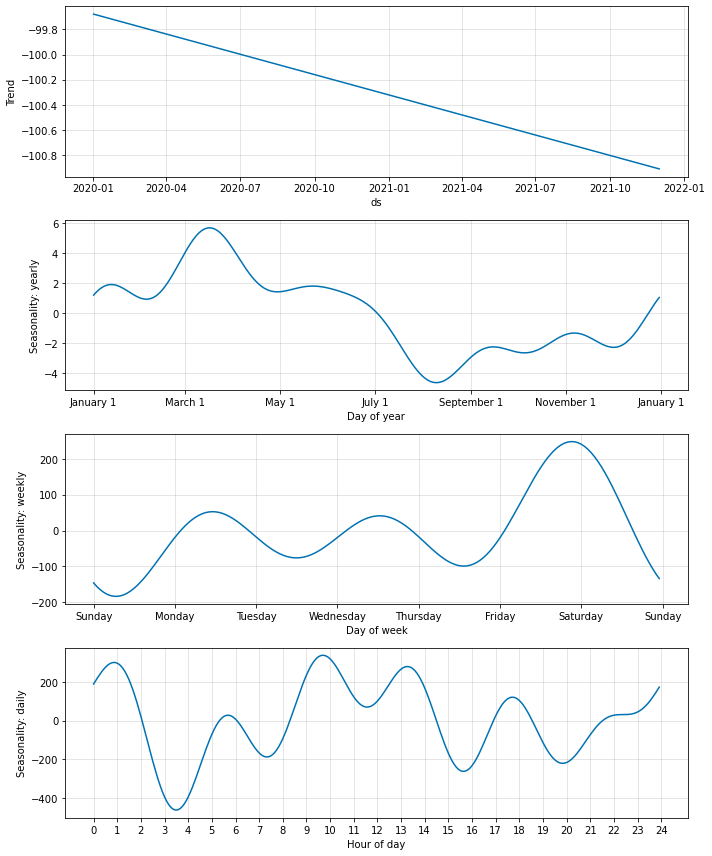

In [30]:
fig_comp1_test = m1.plot_components(predicted_test1)

INFO - (NP.forecaster._handle_missing_data) - 2276 missing dates added.
INFO - (NP.forecaster._handle_missing_data) - 2276 NaN values in column y were auto-imputed.


  0%|          | 0/292 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 8.88E-03, min: 1.05E+00


  0%|          | 0/292 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 8.88E-03, min: 1.13E+00


  0%|          | 0/292 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 8.88E-03, min: 1.13E+00
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 8.88E-03
Epoch[5/5]: 100%|██████████| 5/5 [00:01<00:00,  4.18it/s, SmoothL1Loss=0.00391, MAE=13.4, RMSE=16.4, RegLoss=0]
INFO - (NP.forecaster._handle_missing_data) - 2276 missing dates added.
INFO - (NP.forecaster._handle_missing_data) - 2276 NaN values in column y were auto-imputed.
WARNING - (NP.plotting.plot) - Legend is available only for the ten first handles


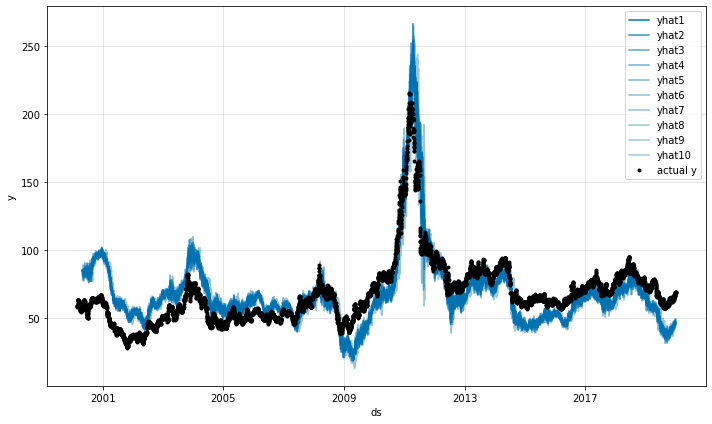

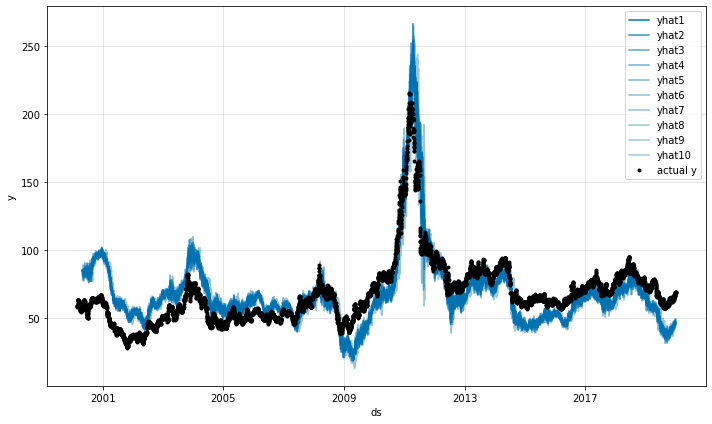

In [42]:
#BASE model

m2 = NeuralProphet(daily_seasonality=True, n_lags=60,n_forecasts=10, epochs=5, batch_size=100, normalize='minmax')

metrics2 = m2.fit(df_prophet, freq='D')
predicted2 = m2.predict(df_prophet)
m2.plot(predicted2)


INFO - (NP.forecaster._handle_missing_data) - 215 missing dates added.
INFO - (NP.forecaster._handle_missing_data) - 215 NaN values in column y were auto-imputed.
WARNING - (NP.plotting.plot) - Legend is available only for the ten first handles


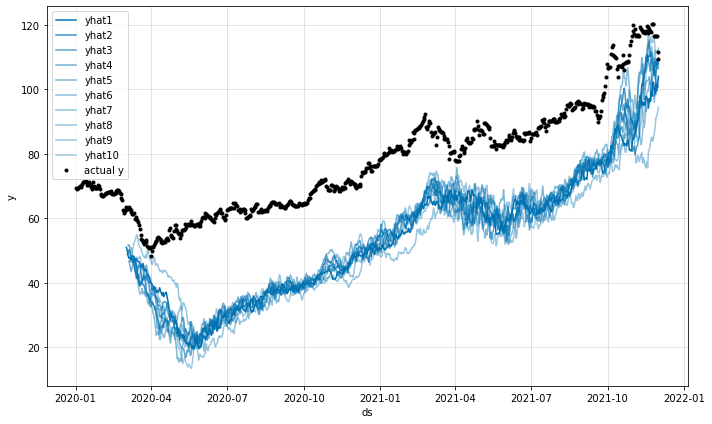

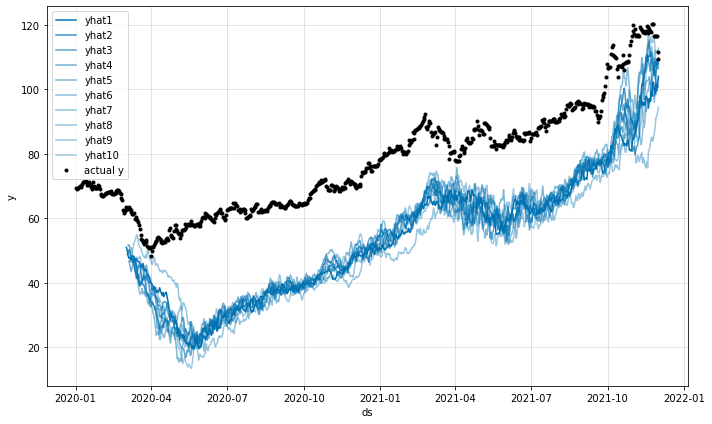

In [43]:
predicted_test2 = m2.predict(test_df1)
m2.plot(predicted_test2)

INFO - (NP.forecaster._handle_missing_data) - 2276 missing dates added.
INFO - (NP.forecaster._handle_missing_data) - 2276 NaN values in column y were auto-imputed.


  0%|          | 0/292 [00:00<?, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /opt/conda/lib/python3.8/site-packages/torch/nn/modules/container.py:552: UserWarning: Setting attributes on ParameterDict is not supported.
  warnings.warn("Setting attributes on ParameterDict is not supported.")

WARNING - (py.warnings._showwarnmsg) - /opt/conda/lib/python3.8/site-packages/torch/autograd/__init__.py:130: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:100.)
  Variable._execution_engine.run_backward(

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 3.69E-02, min: 4.15E-01


  0%|          | 0/292 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 3.96E-02, min: 4.15E-01


  0%|          | 0/292 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 3.20E-02, min: 4.79E-01
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 3.60E-02
Epoch[10/10]: 100%|██████████| 10/10 [00:01<00:00,  5.42it/s, SmoothL1Loss=0.000225, MAE=2.68, RMSE=3.9, RegLoss=0]
INFO - (NP.forecaster._handle_missing_data) - 2276 missing dates added.
INFO - (NP.forecaster._handle_missing_data) - 2276 NaN values in column y were auto-imputed.


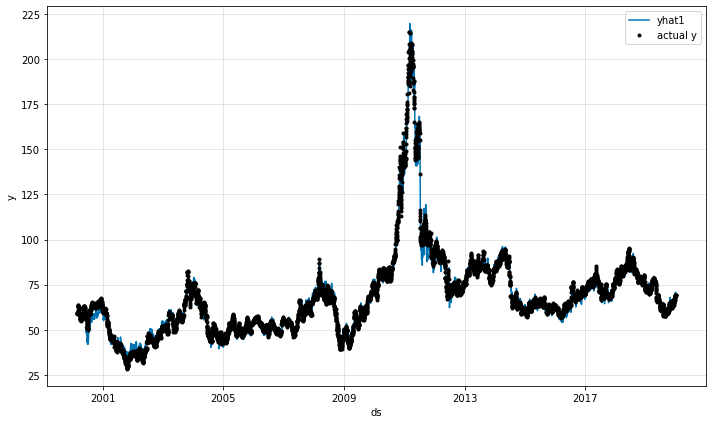

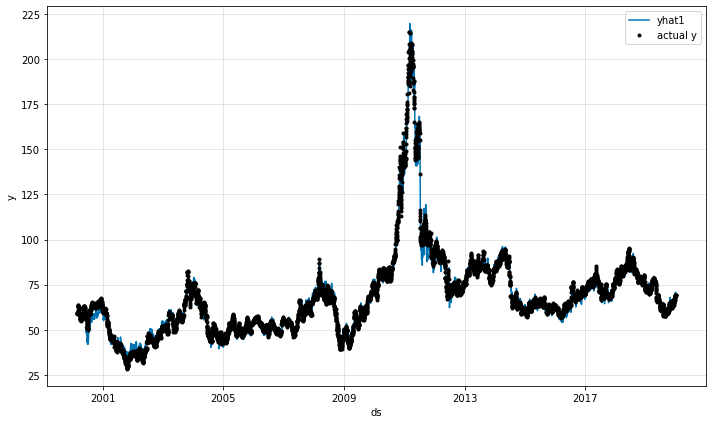

In [13]:
#BASE model

m2 = NeuralProphet(daily_seasonality=False, n_lags=100,n_forecasts=5, n_changepoints=50, epochs=50, batch_size=256, normalize='minmax')

metrics2 = m2.fit(df_prophet, freq='D')
predicted2 = m2.predict(df_prophet)
m2.plot(predicted2)


INFO - (NP.forecaster._handle_missing_data) - 215 missing dates added.
INFO - (NP.forecaster._handle_missing_data) - 215 NaN values in column y were auto-imputed.
WARNING - (py.warnings._showwarnmsg) - /opt/conda/lib/python3.8/site-packages/torch/nn/modules/container.py:552: UserWarning: Setting attributes on ParameterDict is not supported.
  warnings.warn("Setting attributes on ParameterDict is not supported.")



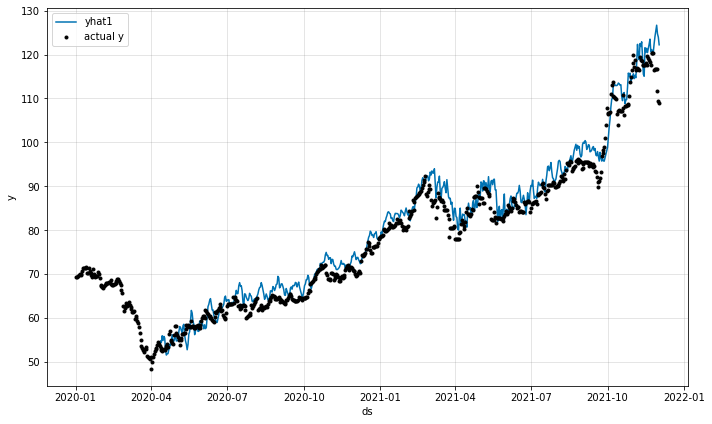

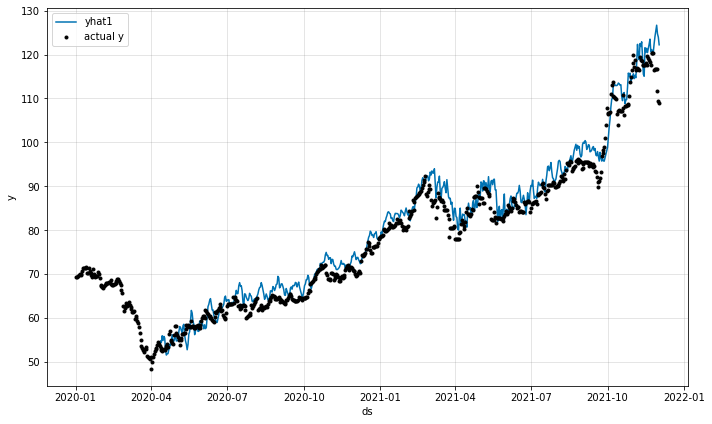

In [14]:
predicted_test2 = m2.predict(test_df1)
m2.plot(predicted_test2)

In [34]:
ds_f=pd.DataFrame({'ds':pd.date_range(start='2020-1-1', end='2022-12-31')})

In [43]:
predicted_test2.head(102)

ds          y      yhat1 residual1        ar1      trend  \
0   2020-01-02  69.269997       None      None       None       None   
1   2020-01-03  69.199997       None      None       None       None   
2   2020-01-04  69.479998       None      None       None       None   
3   2020-01-05  69.760000       None      None       None       None   
4   2020-01-06  70.040001       None      None       None       None   
..         ...        ...        ...       ...        ...        ...   
97  2020-04-08  53.840000       None       NaN       None       None   
98  2020-04-09  54.369999       None       NaN       None       None   
99  2020-04-10  53.967499       None       NaN       None       None   
100 2020-04-11  53.564999  53.922184  0.357185  23.479187  30.596275   
101 2020-04-12  53.162498  54.732292  1.569794  24.326618  30.599106   

    season_yearly season_weekly  
0            None          None  
1            None          None  
2            None          None  
3            None          None  
4            None          None  
..            ...           ...  
97           None          None  
98           None          None  
99           None          None  
100     -0.284841      0.131565  
101     -0.274129      0.080696  

[102 rows x 8 columns]

In [35]:
ds_f.tail()

ds
1091 2022-12-27
1092 2022-12-28
1093 2022-12-29
1094 2022-12-30
1095 2022-12-31

In [38]:
test_df1

ds           y
0   2020-01-02   69.269997
1   2020-01-03   69.199997
2   2020-01-06   70.040001
3   2020-01-07   69.830002
4   2020-01-08   69.959999
..         ...         ...
481 2021-11-26  116.599998
482 2021-11-29  116.650002
483 2021-11-30  111.650002
484 2021-12-01  109.389999
485 2021-12-02  108.900002

[486 rows x 2 columns]

In [23]:
future.tail()

ds          y
4965 2019-12-26  68.699997
4966 2019-12-27  68.919998
4967 2019-12-30  69.559998
4968 2019-12-31  69.050003
4969 2020-01-01        NaN

In [22]:
df_prophet.tail()

ds          y
4964 2019-12-24  68.699997
4965 2019-12-26  68.699997
4966 2019-12-27  68.919998
4967 2019-12-30  69.559998
4968 2019-12-31  69.050003

In [47]:
!pip3 install gapandas
import gapandas as gp

     |████████████████████████████████| 7.8 MB 5.0 MB/s eta 0:00:01
  Using cached oauth2client-4.1.3-py2.py3-none-any.whl (98 kB)
     |████████████████████████████████| 95 kB 10.7 MB/s  eta 0:00:01
  Using cached uritemplate-4.1.1-py2.py3-none-any.whl (10 kB)
     |████████████████████████████████| 96 kB 11.9 MB/s  eta 0:00:01
  Using cached google_auth_httplib2-0.1.0-py2.py3-none-any.whl (9.3 kB)
  Using cached googleapis_common_protos-1.53.0-py2.py3-none-any.whl (198 kB)


In [49]:
from neuralprophet import set_random_seed 
set_random_seed(123)

In [56]:
df_prophet.tail()

ds          y
4964 2019-12-24  68.699997
4965 2019-12-26  68.699997
4966 2019-12-27  68.919998
4967 2019-12-30  69.559998
4968 2019-12-31  69.050003

WARNING - (NP.forecaster._make_future_dataframe) - Number of forecast steps is defined by n_forecasts. Adjusted to 10.
INFO - (NP.forecaster._handle_missing_data) - 2276 missing dates added.
INFO - (NP.forecaster._handle_missing_data) - 2276 NaN values in column y were auto-imputed.
WARNING - (NP.plotting.plot) - Legend is available only for the ten first handles


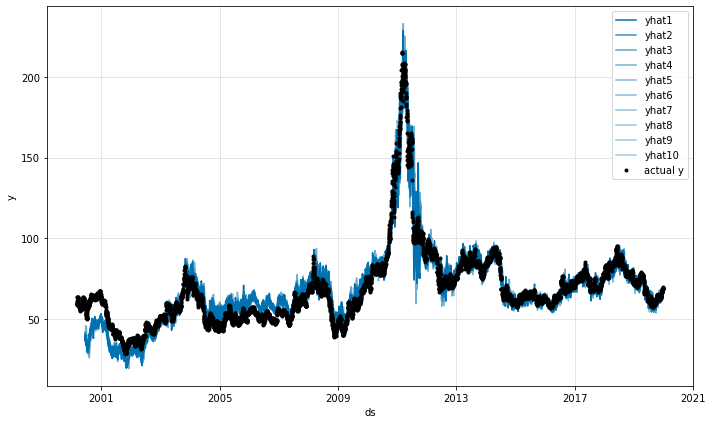

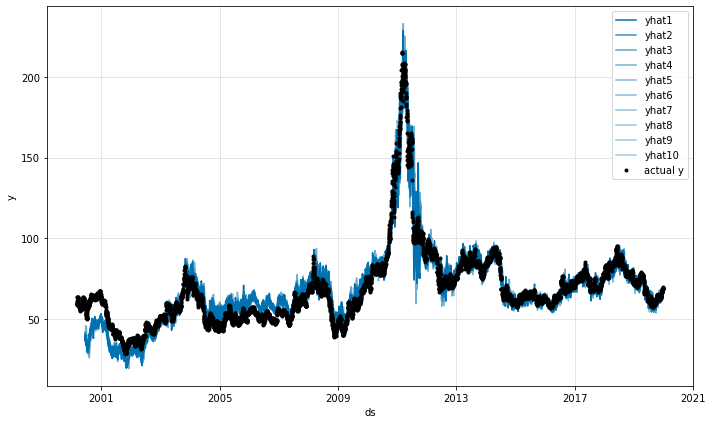

In [60]:
future = m2.make_future_dataframe(df_prophet, periods=365*2, n_historic_predictions=True)
forecast = m2.predict(future)
m2.plot(forecast)

In [61]:
forecast.tail()

ds   y yhat1 residual1 yhat2 residual2 yhat3 residual3 yhat4  \
7250 2020-01-06 NaN  None       NaN  None       NaN  None       NaN  None   
7251 2020-01-07 NaN  None       NaN  None       NaN  None       NaN  None   
7252 2020-01-08 NaN  None       NaN  None       NaN  None       NaN  None   
7253 2020-01-09 NaN  None       NaN  None       NaN  None       NaN  None   
7254 2020-01-10 NaN  None       NaN  None       NaN  None       NaN  None   

     residual4  ...   ar5        ar6        ar7        ar8        ar9  \
7250       NaN  ...  None  39.976913  38.529202  40.912224  41.376652   
7251       NaN  ...  None       None  39.540504  40.225212  41.143772   
7252       NaN  ...  None       None       None  40.826874  41.159859   
7253       NaN  ...  None       None       None       None  40.265747   
7254       NaN  ...  None       None       None       None       None   

           ar10       trend season_yearly season_weekly season_daily  
7250  39.801243   127.44577      0.650388      0.021627  -100.441437  
7251  40.549427   127.44577      0.564959     -0.032454  -100.441437  
7252  40.343754  127.445755      0.479225      0.038021  -100.441437  
7253  40.810673   127.44574      0.394093     -0.066441  -100.441437  
7254  40.266949  127.445724       0.31046     -0.051545  -100.441437  

[5 rows x 36 columns]

INFO - (NP.forecaster._handle_missing_data) - 2276 missing dates added.
INFO - (NP.forecaster._handle_missing_data) - 2276 NaN values in column y were auto-imputed.


  0%|          | 0/292 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 5.27E-02, min: 3.60E-01


  0%|          | 0/292 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 3.20E-02, min: 4.15E-01


  0%|          | 0/292 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 3.20E-02, min: 3.87E-01
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 3.78E-02
Epoch[5/5]: 100%|██████████| 5/5 [00:01<00:00,  2.98it/s, SmoothL1Loss=0.00165, MAE=7.12, RMSE=10.7, RegLoss=0]
INFO - (NP.forecaster._handle_missing_data) - 2276 missing dates added.
INFO - (NP.forecaster._handle_missing_data) - 2276 NaN values in column y were auto-imputed.
WARNING - (NP.plotting.plot) - Legend is available only for the ten first handles


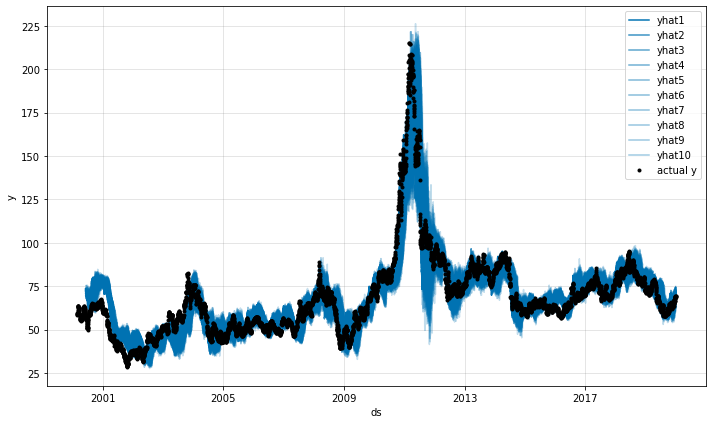

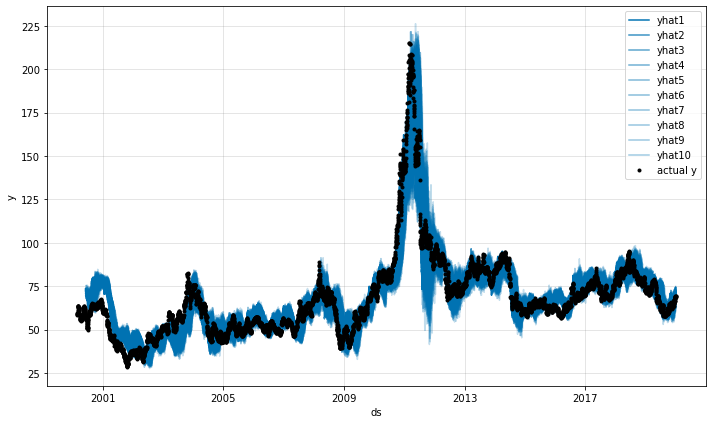

In [72]:
#BASE model

m = NeuralProphet(daily_seasonality=True, n_lags=100,n_forecasts=100, epochs=5, batch_size=100, normalize='minmax')

metrics = m.fit(df_prophet, freq='D')
predicted = m.predict(df_prophet)
m.plot(predicted)


INFO - (NP.forecaster._handle_missing_data) - 215 missing dates added.
INFO - (NP.forecaster._handle_missing_data) - 215 NaN values in column y were auto-imputed.
WARNING - (NP.plotting.plot) - Legend is available only for the ten first handles


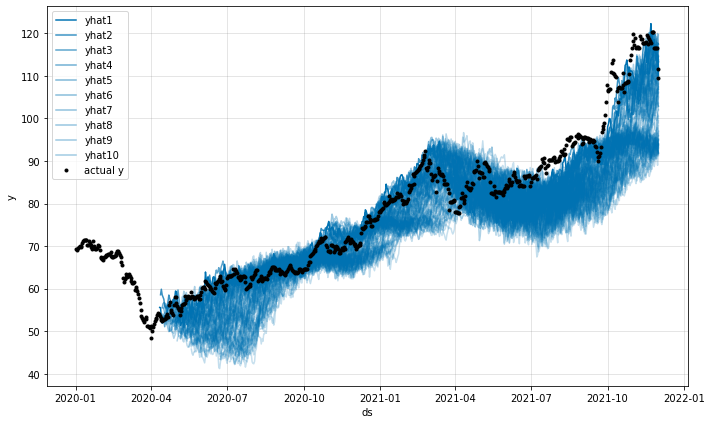

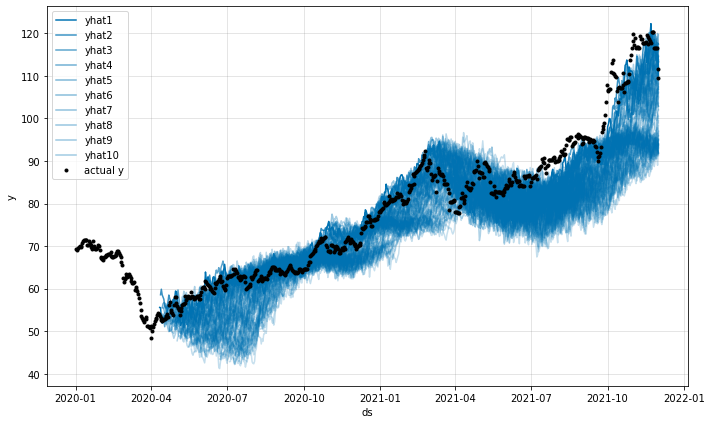

In [73]:
predicted_test = m.predict(test_df1)
m.plot(predicted_test)

INFO - (NP.forecaster._handle_missing_data) - 2276 missing dates added.
INFO - (NP.forecaster._handle_missing_data) - 2276 NaN values in column y were auto-imputed.
WARNING - (NP.plotting.plot) - Legend is available only for the ten first handles


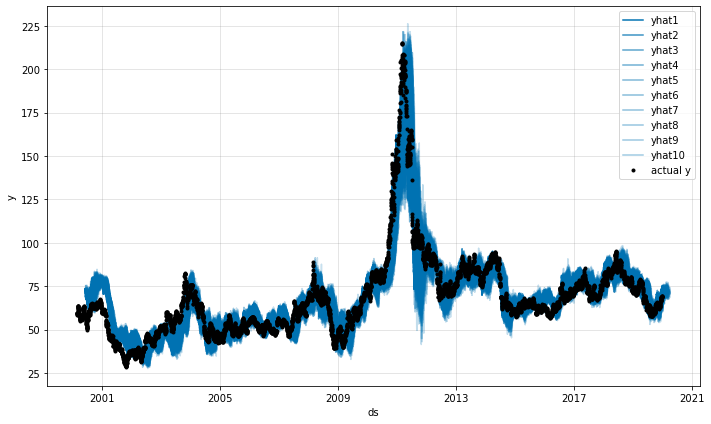

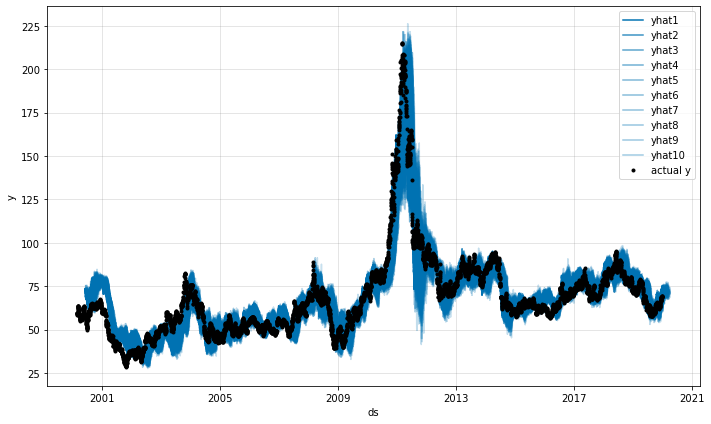

In [74]:
future = m.make_future_dataframe(df_prophet, periods=100, n_historic_predictions=True)
forecast = m.predict(future)
m2.plot(forecast)

In [77]:
forecast.tail(100)

ds   y      yhat1 residual1      yhat2 residual2      yhat3  \
7245 2020-01-01 NaN  74.064041       NaN  72.436234       NaN  73.960159   
7246 2020-01-02 NaN       None       NaN  72.432701       NaN  73.747833   
7247 2020-01-03 NaN       None       NaN       None       NaN  74.814041   
7248 2020-01-04 NaN       None       NaN       None       NaN       None   
7249 2020-01-05 NaN       None       NaN       None       NaN       None   
...         ...  ..        ...       ...        ...       ...        ...   
7340 2020-04-05 NaN       None       NaN       None       NaN       None   
7341 2020-04-06 NaN       None       NaN       None       NaN       None   
7342 2020-04-07 NaN       None       NaN       None       NaN       None   
7343 2020-04-08 NaN       None       NaN       None       NaN       None   
7344 2020-04-09 NaN       None       NaN       None       NaN       None   

     residual3      yhat4 residual4  ...       ar95       ar96       ar97  \
7245       NaN  73.913742       NaN  ...  25.710367  26.557652  20.867073   
7246       NaN  74.461563       NaN  ...  24.553764  24.642847  21.697252   
7247       NaN  74.707733       NaN  ...  24.850216  25.844244   23.65193   
7248       NaN  75.280167       NaN  ...  23.860407  24.703627  23.238083   
7249       NaN       None       NaN  ...   25.84692  24.998547  22.199017   
...        ...        ...       ...  ...        ...        ...        ...   
7340       NaN       None       NaN  ...       None  35.937504  34.875656   
7341       NaN       None       NaN  ...       None       None  34.461052   
7342       NaN       None       NaN  ...       None       None       None   
7343       NaN       None       NaN  ...       None       None       None   
7344       NaN       None       NaN  ...       None       None       None   

           ar98       ar99      ar100      trend season_yearly season_weekly  \
7245  23.621521  23.456394  26.942495   81.14505      2.821881      0.025625   
7246  25.385071  23.818289   25.66572  81.142899      2.854124     -0.003373   
7247  25.579988  24.271114  24.488474  81.140747      2.879611     -0.021847   
7248  24.561598  22.812304   23.48694  81.138596      2.898485      0.017812   
7249  25.094185  23.023399  23.064032  81.136429      2.910949     -0.007125   
...         ...        ...        ...        ...           ...           ...   
7340  33.918358  36.128025  31.583994  80.940414      1.191624     -0.007125   
7341  34.754215  37.429016  32.767757  80.938263      1.104271      0.007013   
7342  36.388672  37.165192   34.57103  80.936104       1.01695     -0.018104   
7343       None  37.521896  35.032974  80.933952      0.929499      0.025625   
7344       None       None  34.195171  80.931793      0.841736     -0.003373   

     season_daily  
7245   -45.256886  
7246   -45.256886  
7247   -45.256886  
7248   -45.256886  
7249   -45.256886  
...           ...  
7340   -45.256886  
7341   -45.256886  
7342   -45.256886  
7343   -45.256886  
7344   -45.256886  

[100 rows x 306 columns]

INFO - (NP.forecaster._handle_missing_data) - 2276 missing dates added.
INFO - (NP.forecaster._handle_missing_data) - 2276 NaN values in column y were auto-imputed.
Epoch[50/50]: 100%|██████████| 50/50 [00:05<00:00,  8.52it/s, SmoothL1Loss=0.000115, MAE=1.81, RMSE=2.81, RegLoss=0]
INFO - (NP.forecaster._handle_missing_data) - 2276 missing dates added.
INFO - (NP.forecaster._handle_missing_data) - 2276 NaN values in column y were auto-imputed.


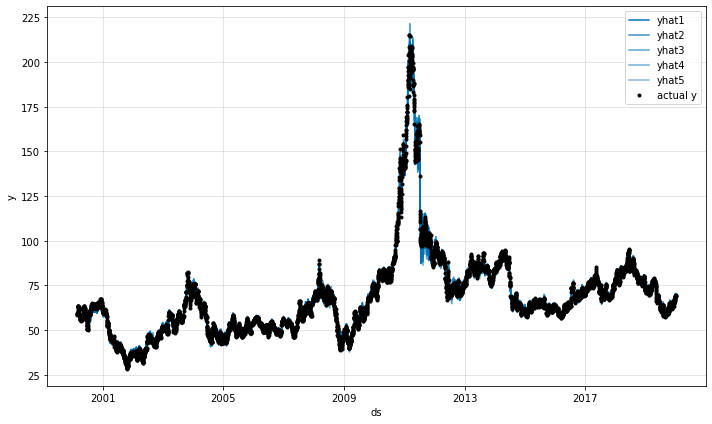

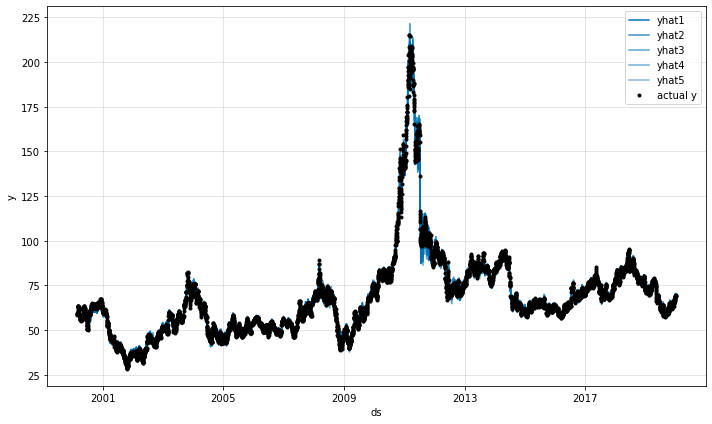

In [42]:
#BASE model

m2 = NeuralProphet(daily_seasonality=False, n_lags=150, n_forecasts=5, epochs=50, batch_size=256, learning_rate=0.1, normalize='minmax')

metrics2 = m2.fit(df_prophet, freq='D')
predicted2 = m2.predict(df_prophet)
m2.plot(predicted2)

INFO - (NP.forecaster._handle_missing_data) - 215 missing dates added.
INFO - (NP.forecaster._handle_missing_data) - 215 NaN values in column y were auto-imputed.


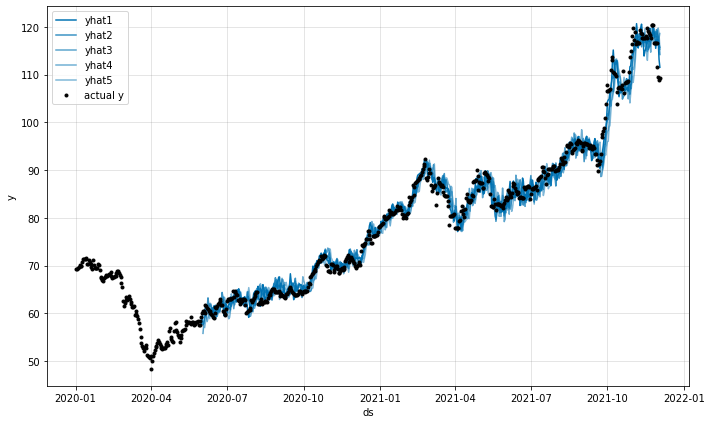

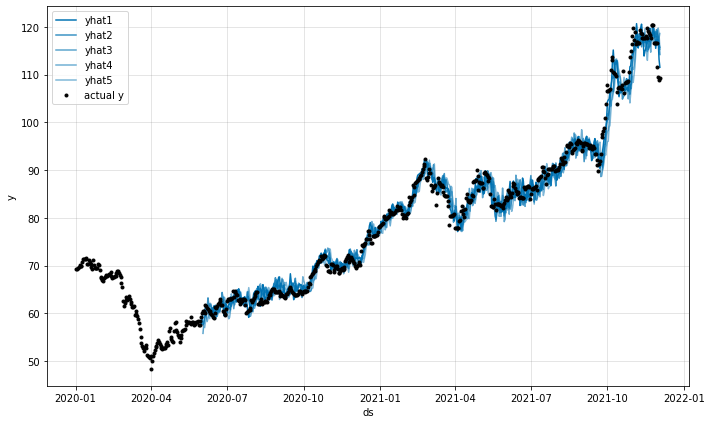

In [44]:
predicted_test = m2.predict(test_df1)
m2.plot(predicted_test)

In [25]:
df_prophet.head()

ds          y
0 2000-03-01  59.500000
1 2000-03-02  58.650002
2 2000-03-03  59.049999
3 2000-03-06  59.400002
4 2000-03-07  59.650002

In [26]:
test_df1.head()

ds          y
0 2020-01-02  69.269997
1 2020-01-03  69.199997
2 2020-01-06  70.040001
3 2020-01-07  69.830002
4 2020-01-08  69.959999

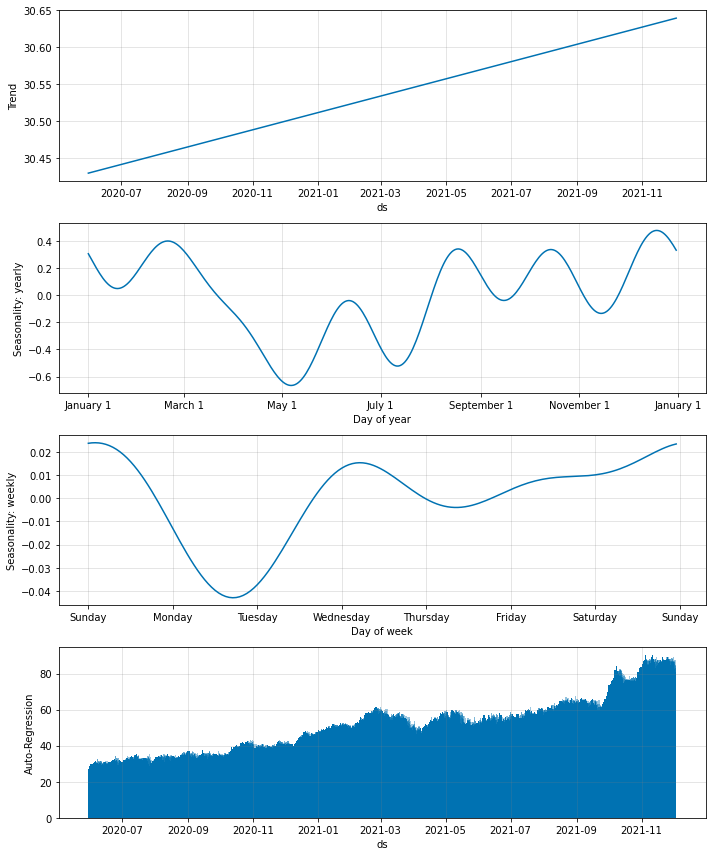

In [45]:
fig_comp1 = m2.plot_components(predicted_test)

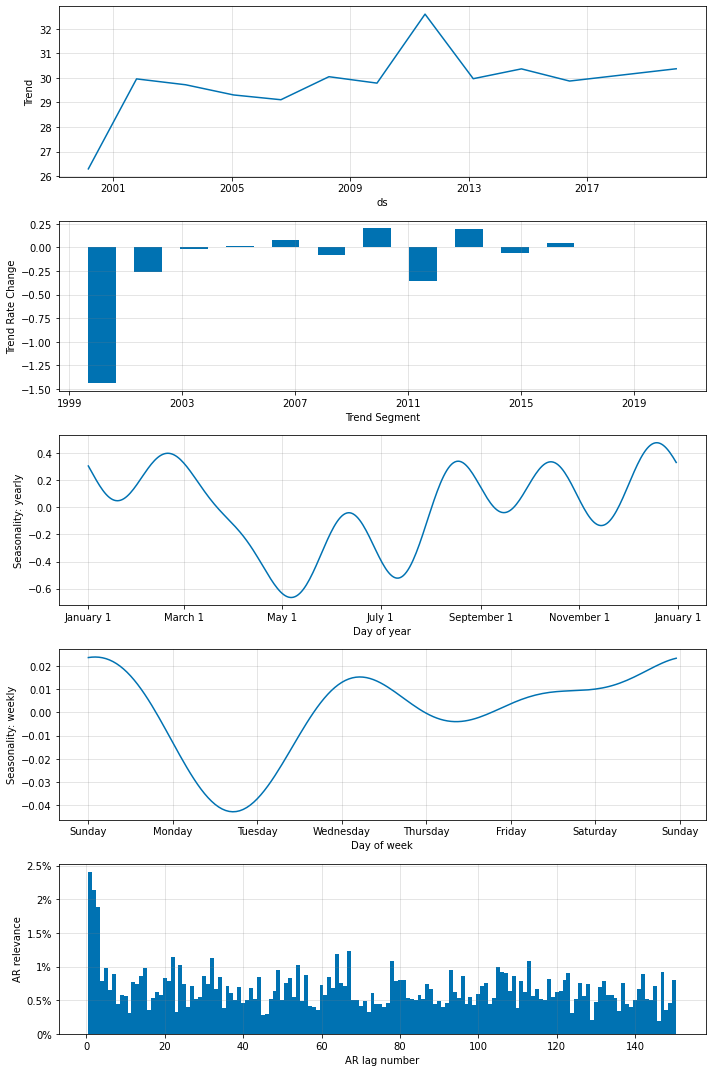

In [46]:
fig_param = m2.plot_parameters()

INFO - (NP.forecaster._handle_missing_data) - 2276 missing dates added.
INFO - (NP.forecaster._handle_missing_data) - 2276 NaN values in column y were auto-imputed.
Epoch[50/50]: 100%|██████████| 50/50 [00:05<00:00,  9.30it/s, SmoothL1Loss=7.9e-5, MAE=1.45, RMSE=2.32, RegLoss=0]  
INFO - (NP.forecaster._handle_missing_data) - 2276 missing dates added.
INFO - (NP.forecaster._handle_missing_data) - 2276 NaN values in column y were auto-imputed.


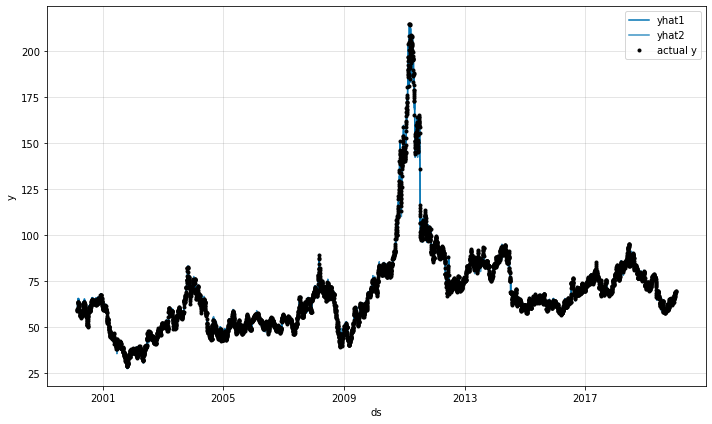

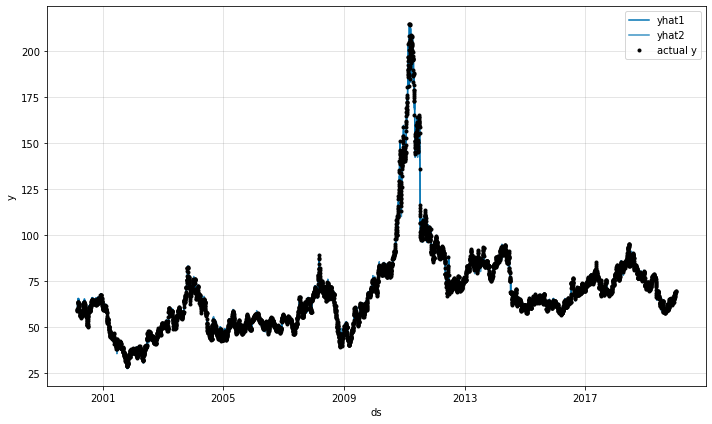

In [47]:
m2 = NeuralProphet(daily_seasonality=False, n_lags=3, n_forecasts=2, epochs=50, batch_size=256, learning_rate=0.1, normalize='minmax')

metrics2 = m2.fit(df_prophet, freq='D')
predicted2 = m2.predict(df_prophet)
m2.plot(predicted2)

INFO - (NP.forecaster._handle_missing_data) - 215 missing dates added.
INFO - (NP.forecaster._handle_missing_data) - 215 NaN values in column y were auto-imputed.


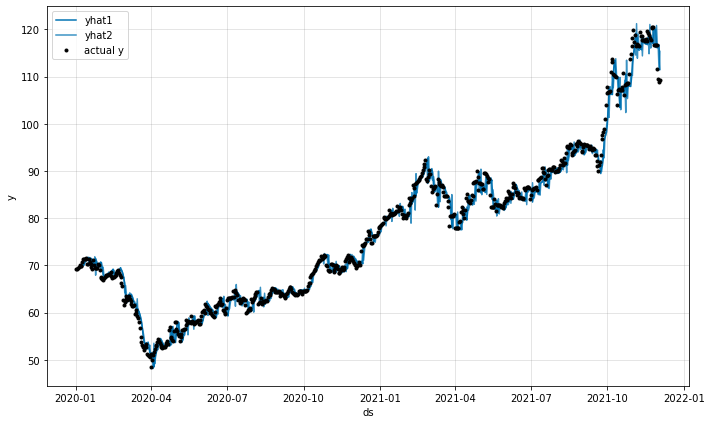

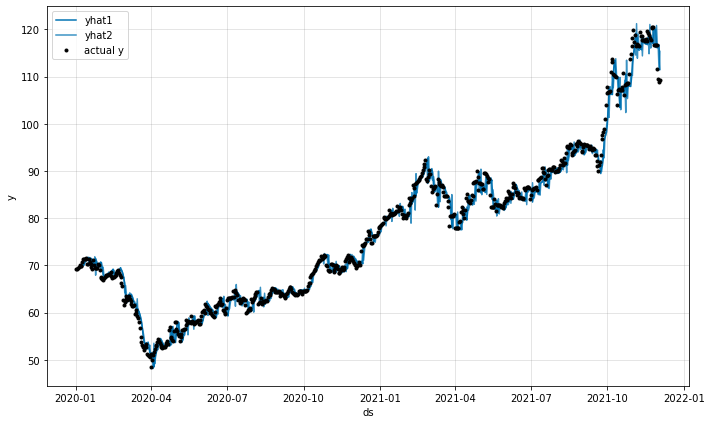

In [48]:
predicted_test = m2.predict(test_df1)
m2.plot(predicted_test)

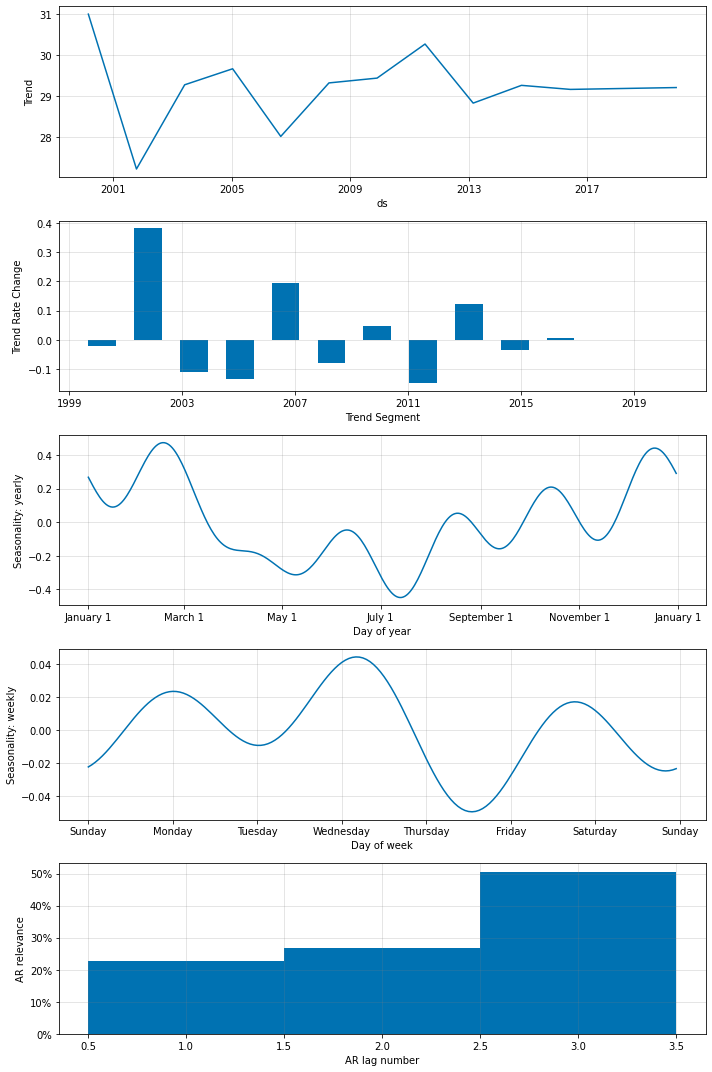

In [49]:
fig_param = m2.plot_parameters()

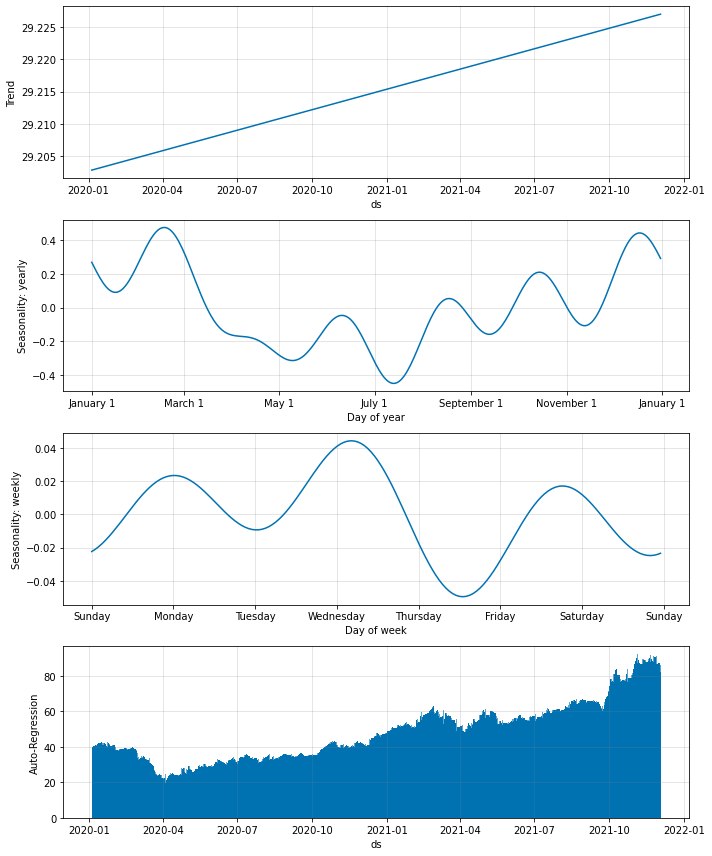

In [50]:
fig_comp1 = m2.plot_components(predicted_test)